# Modélisation

Maintenant qu'on a analysé et traité nos données, on va pouvoir passer à la modélisation. On va essayer différentes méthodes pour créer des segmentation de la clientèle afin de répondre au projet.

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [4]:
RFM_1 = pd.read_csv('RFM_1.csv')
RFM_2 = pd.read_csv('RFM_2.csv')
RFM_3 = pd.read_csv('RFM_3.csv')

## Kmeans

Le modèle que l'on va utiliser principalement est Kmeans, qui permettra de faire du clustering sur nos données, créeant ainsi des catégories de clients qu'on pourra analyser.

### RFM

On va d'abord l'appliquer sur le dataset RFM simple avec les features de bases. Afin d'appliquer le Kmeans, on doit d'abord déterminer le nombre de clusters optimal sur notre dataset.

In [5]:
#On crée une fonction qui permet d'afficher différents graphs de score pour évaluer les clustering afin de trouver un k optimal.
def number_k_graphs(data):
    rcParams['figure.figsize'] = [6.4, 4.8]
    range_n_clusters = [2,3,4,5,6,8]
    silhouette_avg = []
    inertia_distances = []
    calinski_harabasz_scores = []
    for num_clusters in range_n_clusters:
        #On crée un kmeans
        kmeans = KMeans(n_clusters=num_clusters,random_state=10)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        
        #On prend l'inertie pour la méthode du coup
        inertia_distances.append(kmeans.inertia_)

        #Le Silhouette score
        silhouette_avg.append(silhouette_score(data, cluster_labels))
    
        #Et le score Calinski-Harabasz
        calinski_harabasz_scores.append(calinski_harabasz_score(data, cluster_labels))
    

    plt.plot(range_n_clusters,silhouette_avg,'bx-')
    plt.xlabel('Valeurs de K') 
    plt.ylabel('Silhouette score') 
    plt.title('Analyse Silhouette pour K optimal')
    plt.show()


    plt.plot(range_n_clusters,inertia_distances,'bx-')
    plt.xlabel('Valeurs de K') 
    plt.ylabel('Inertie') 
    plt.title('Méthode du coude pour K optimal')
    plt.show()

    plt.plot(range_n_clusters,calinski_harabasz_scores,'bx-')
    plt.xlabel('Valeurs de K') 
    plt.ylabel('Calinski-Harabasz Score') 
    plt.title('Analyse C-H pour K optimal')
    plt.show()
    
    
#On crée également une fonction qui affiche des boxplots des différentes features par cluster    
def clusters_boxplots(k,data,columns):
    for i in k  :
        kmeans = KMeans(n_clusters=i,random_state=10)
        kmeans.fit(data)

        clustered_RFM = pd.concat([data,pd.DataFrame(kmeans.labels_)],axis=1)
        clustered_RFM.rename({0:'clusters'},axis=1,inplace=True)

        print(clustered_RFM.groupby('clusters').mean())

        clustered_RFM['clusters'] = clustered_RFM['clusters'].astype('category')

        rcParams['figure.figsize'] = 20,15
        for column in columns :
            sns.boxplot(data=clustered_RFM,y='clusters',x=column)
            plt.show()
            
        print(clustered_RFM['clusters'].value_counts())

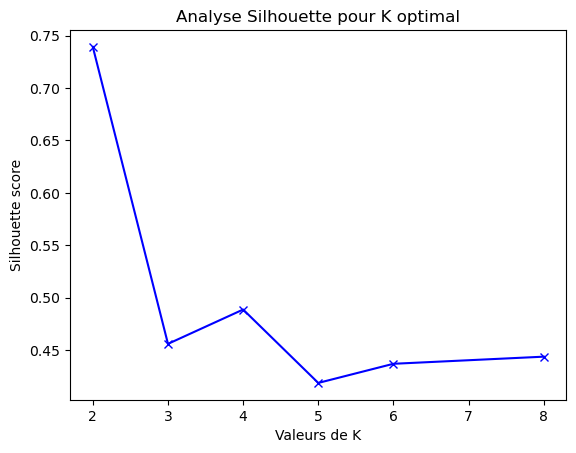

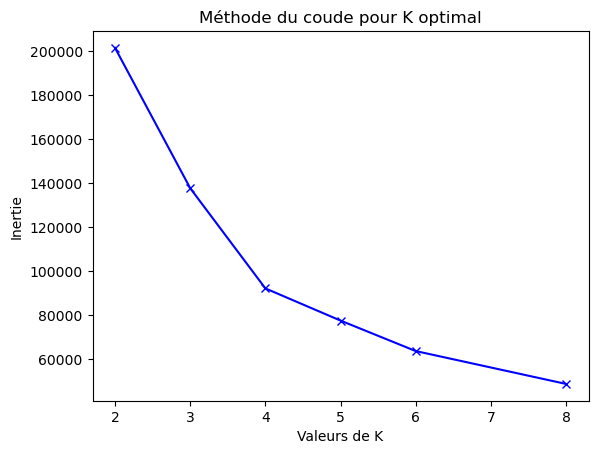

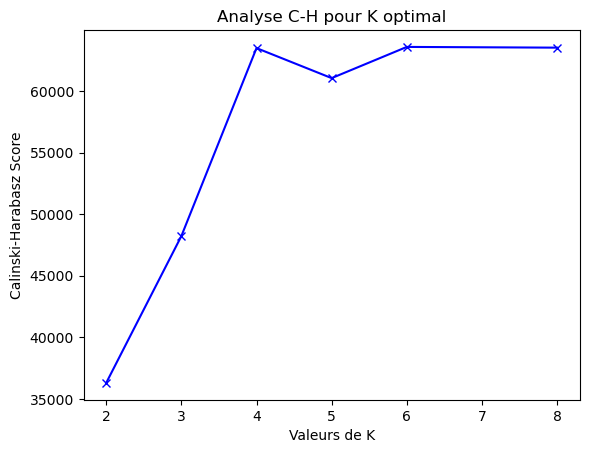

In [6]:
number_k_graphs(RFM_1)

En regardant ces 3 graphs qui nous affichent des scores évaluant la quantité de clusters optimal pour notre problème, on obtient des résultats qu'on va devoir intépréter. 

Sur le graph du silhouette score on voit que le maximum est obtenu pour 2 clusters, ce qui ne sera pas très intéressant pour notre analyse. En continuant à regarder, on voit qu'on descend jusqu'à 3 clusters, avec ensuite un léger rebond à 4 avant de continuer à tomber par la suite. De façon purement numérique, on aurait donc un nombre optimal de clusters à 2, mais comme dit précédemment, on aura du mal à déduire des choses intéressantes de ces clusters, on se retrouve donc ensuite avec notre meilleure valeur à 4 clusters.

Concernant la méthode du coude, on regarde cette fois ci la courbure de notre graph, en trouvant les points de cassure. On peut voir cette fois apparaître une cassure principale en k=4. 

Enfin, on peut calculer le score de Calinski-Harabasz qui vient observer la dispersion intra et extra clusters. On observe ici encore que le meilleur score est obtenu pour k=4.

Avec ces 3 graphs, on peut donc conclure que notre nombre de clusters optimal est 4. Affichons maintenant des boxplots décrivant les clusters crées avec ces paramètres, afin de les analyser et les expliquer.

             count  total_payment   recency
clusters                                   
0        -0.159817      -0.140835  0.979684
1        -0.159817      -0.136635 -0.719861
2        -0.098931       4.384006  0.010399
3         5.169750       0.549968 -0.114625


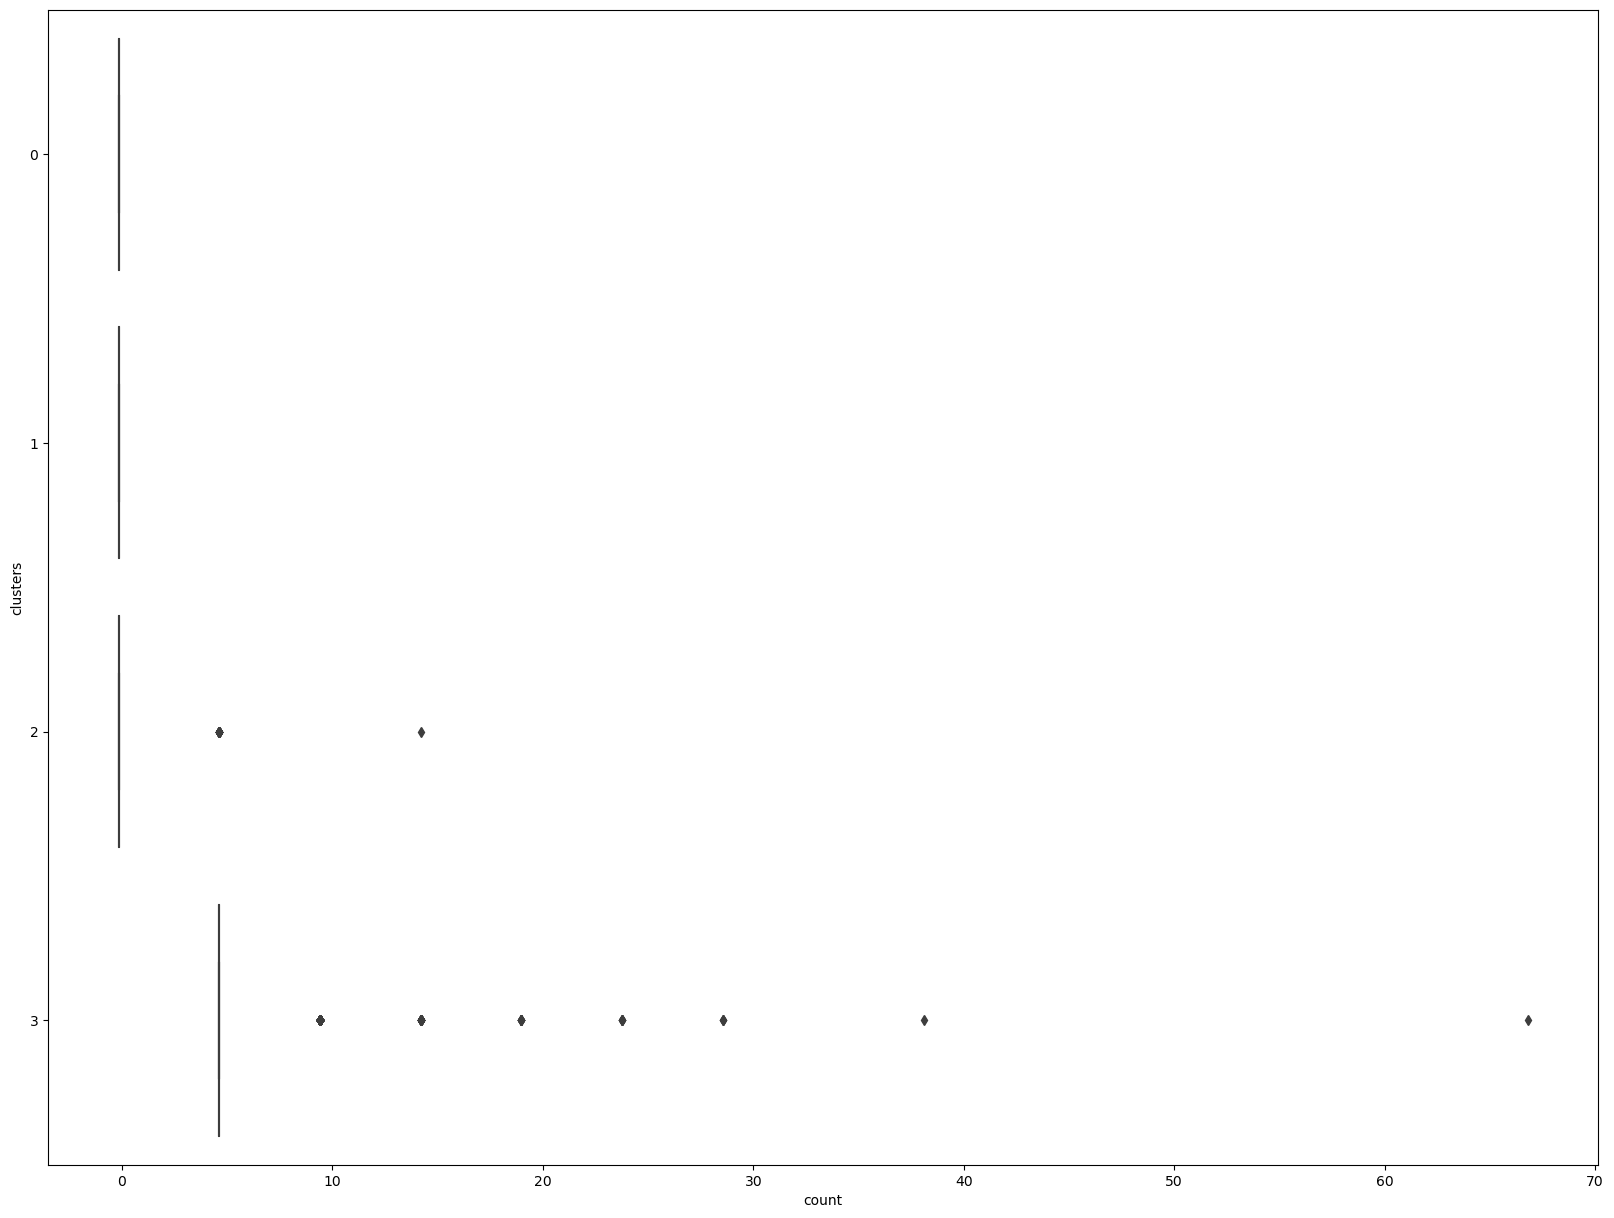

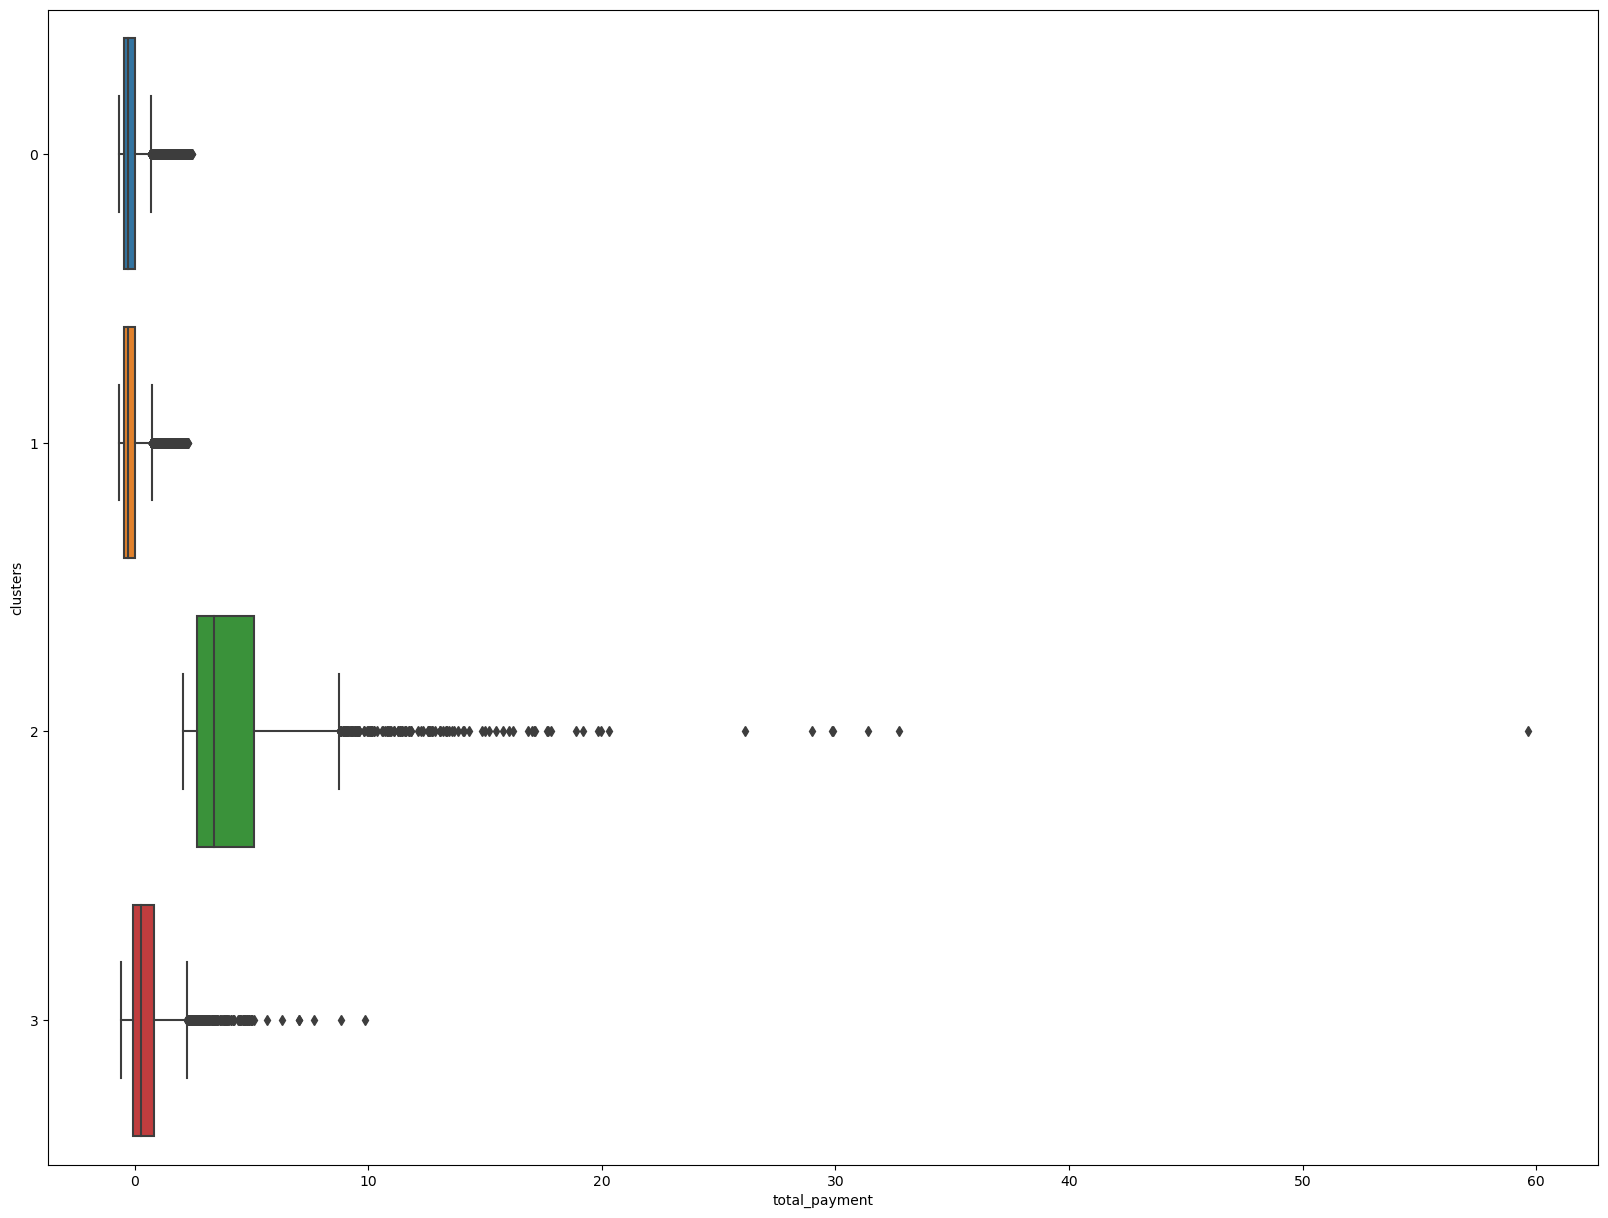

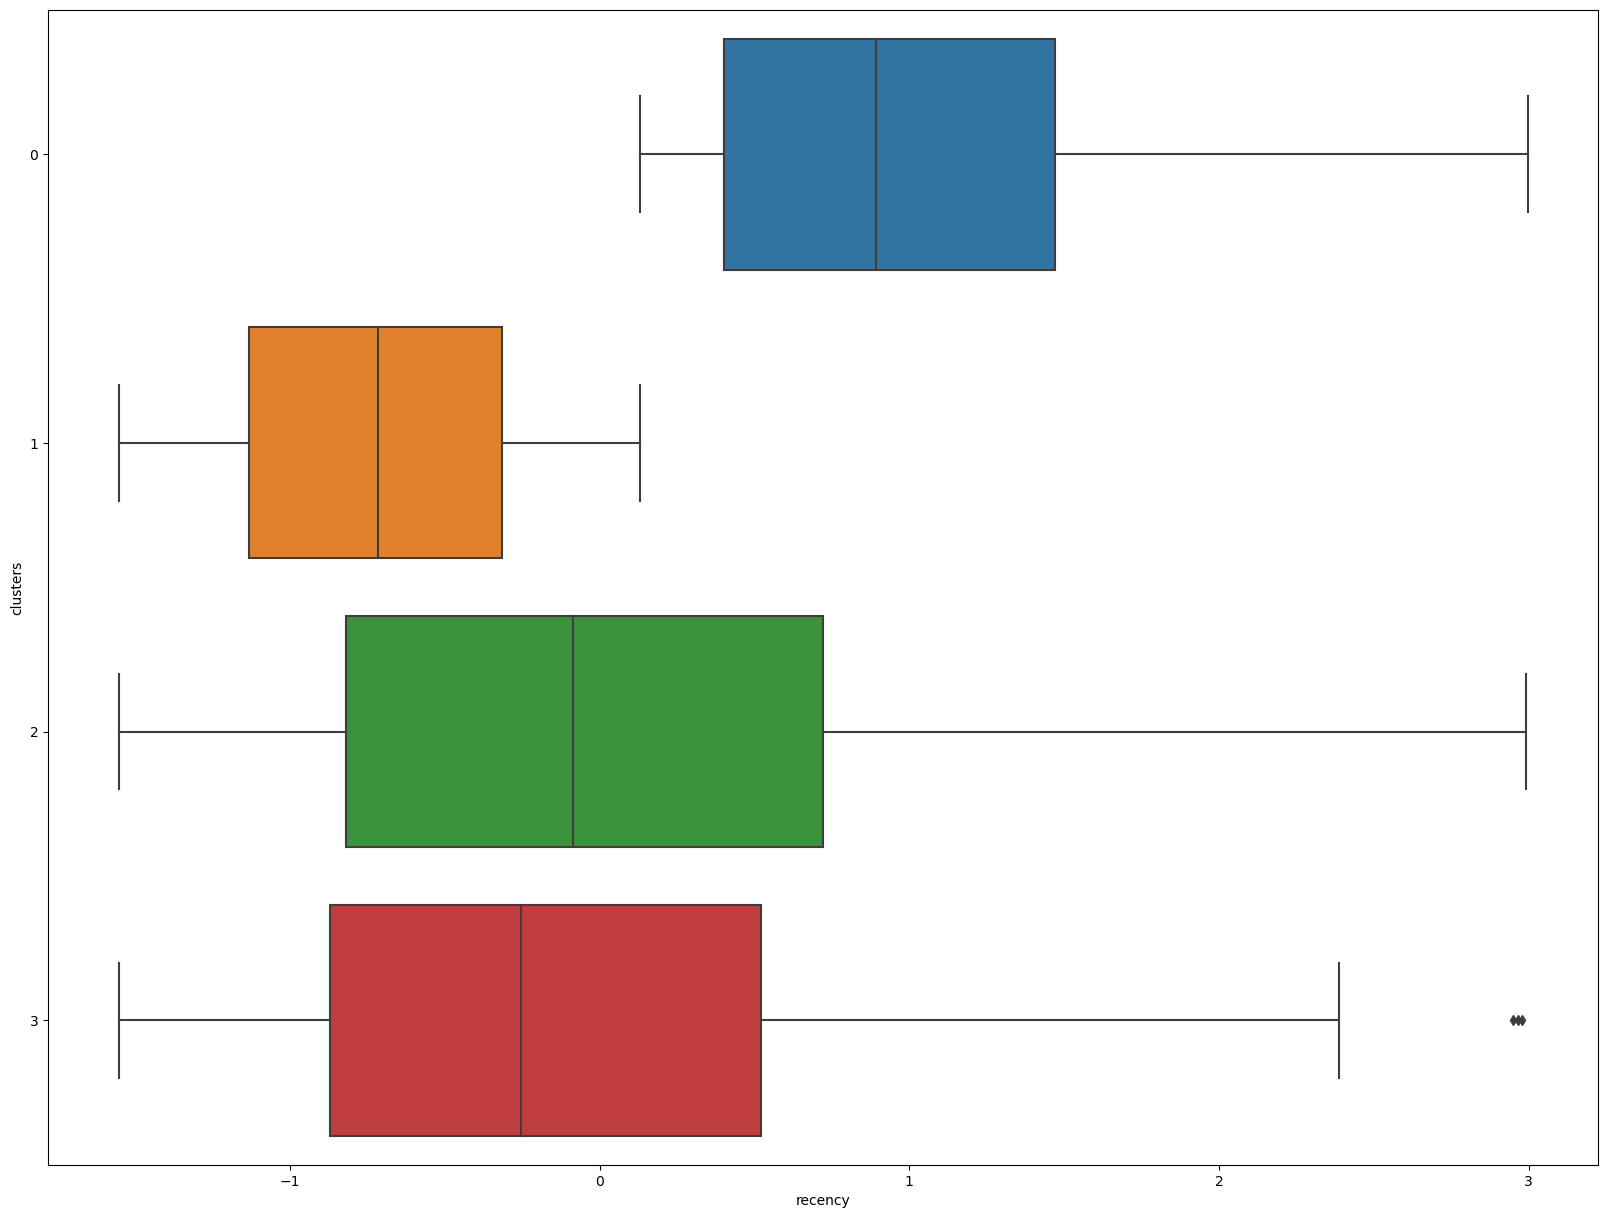

1    50629
0    37500
3     2771
2     2435
Name: clusters, dtype: int64


In [7]:
RFM_1.columns=['count','total_payment','recency']
clusters_boxplots([4],RFM_1,RFM_1.columns)

Avec ces trois graphs, on peut donc expliquer ainsi les clusters formés : 
- Cluster 0 : Clients qui n'ont commandé qu'une seule fois, pour une valeur faible, plutôt récemment.
- Cluster 1 : Clients qui n'ont commandé qu'une seule fois, pour une valeur faible, mais cette fois-ci il y a longtemps
- Cluster 2 : Clients qui commandent majoritairement une seule fois, mais qui achètent des produits chers, sans distinction temporelle
- Cluster 3 : Clients réguliers, sans réelle distinction de temps ou de montant

Il est également intéressant de voir la quantité de population contenue dans chaque clusters. Il apparaît logique que près de 95% des clients soient contenus dans les 2 premiers clusters, comme on sait que seulement 3% des clients commandent plus d'une fois.

### RFM  + Review

On a réussi à identifier des clusters à l'aide du RFM. Il serait cependant intéressant d'également regarder les résultats qu'on obtient en utilisant d'autres features, telles que les catégories de produits commandés ou les notes laissées par les clients.

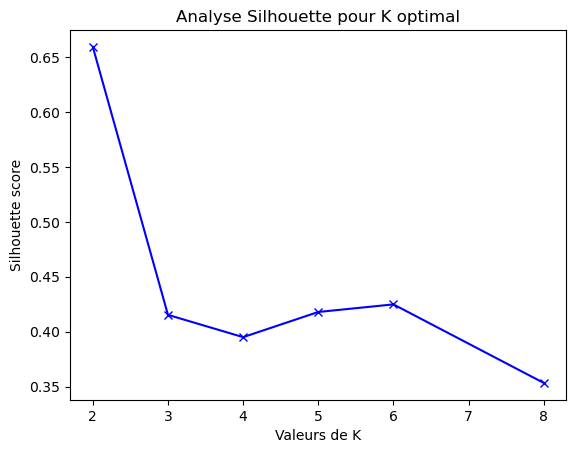

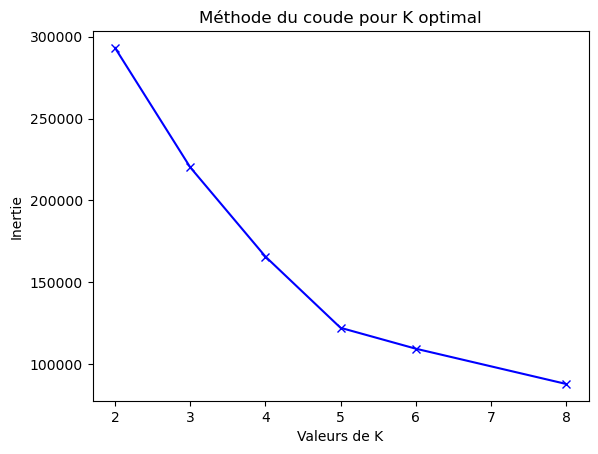

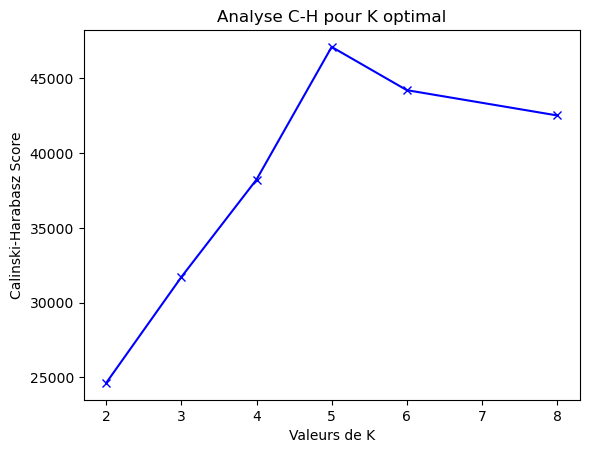

In [11]:
number_k_graphs(RFM_2)

De la même façon que précédemment, le nombre de clusters optimal pour ce dataset semble être k=5.

             count  total_payment   recency    review
clusters                                             
0        -0.160051      -0.140607  1.022061  0.379753
1        -0.160051      -0.143917 -0.752633  0.430778
2        -0.160051      -0.065143 -0.045598 -1.891670
3         5.159966       0.552025 -0.115328  0.047275
4        -0.088443       4.739272 -0.001986 -0.047048


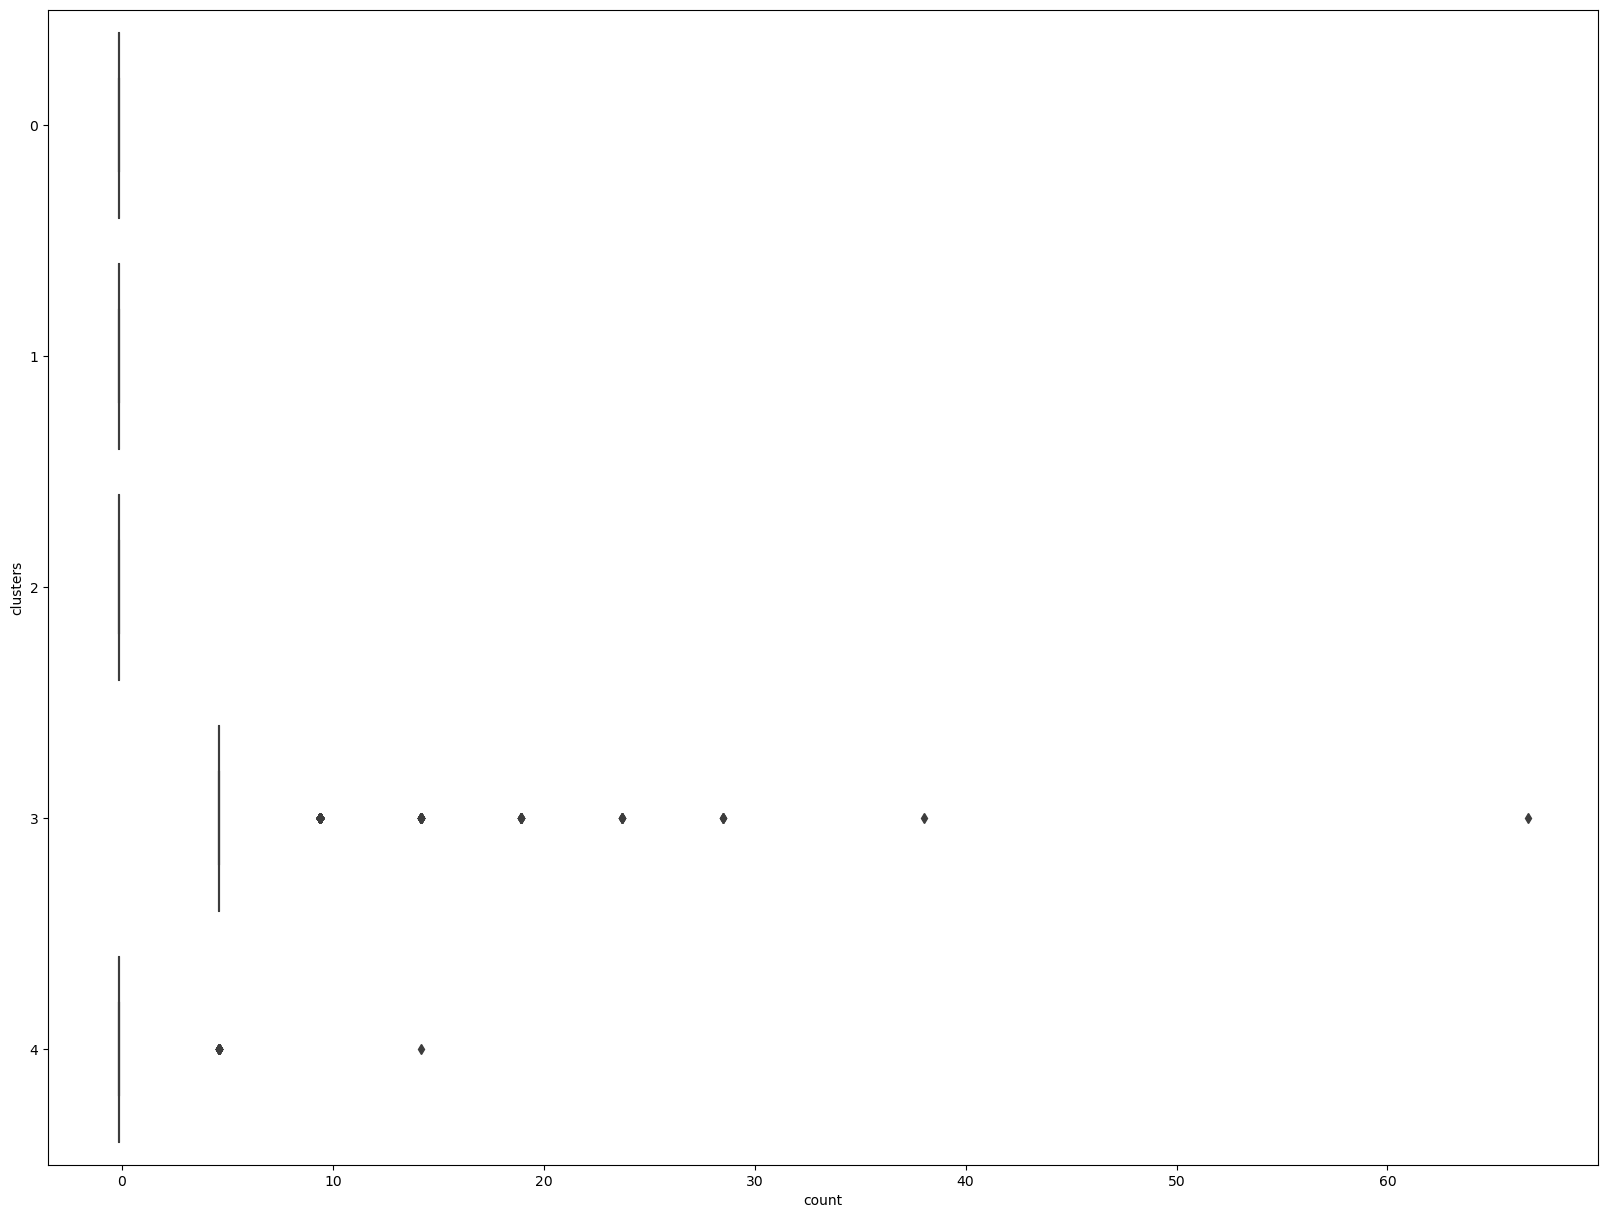

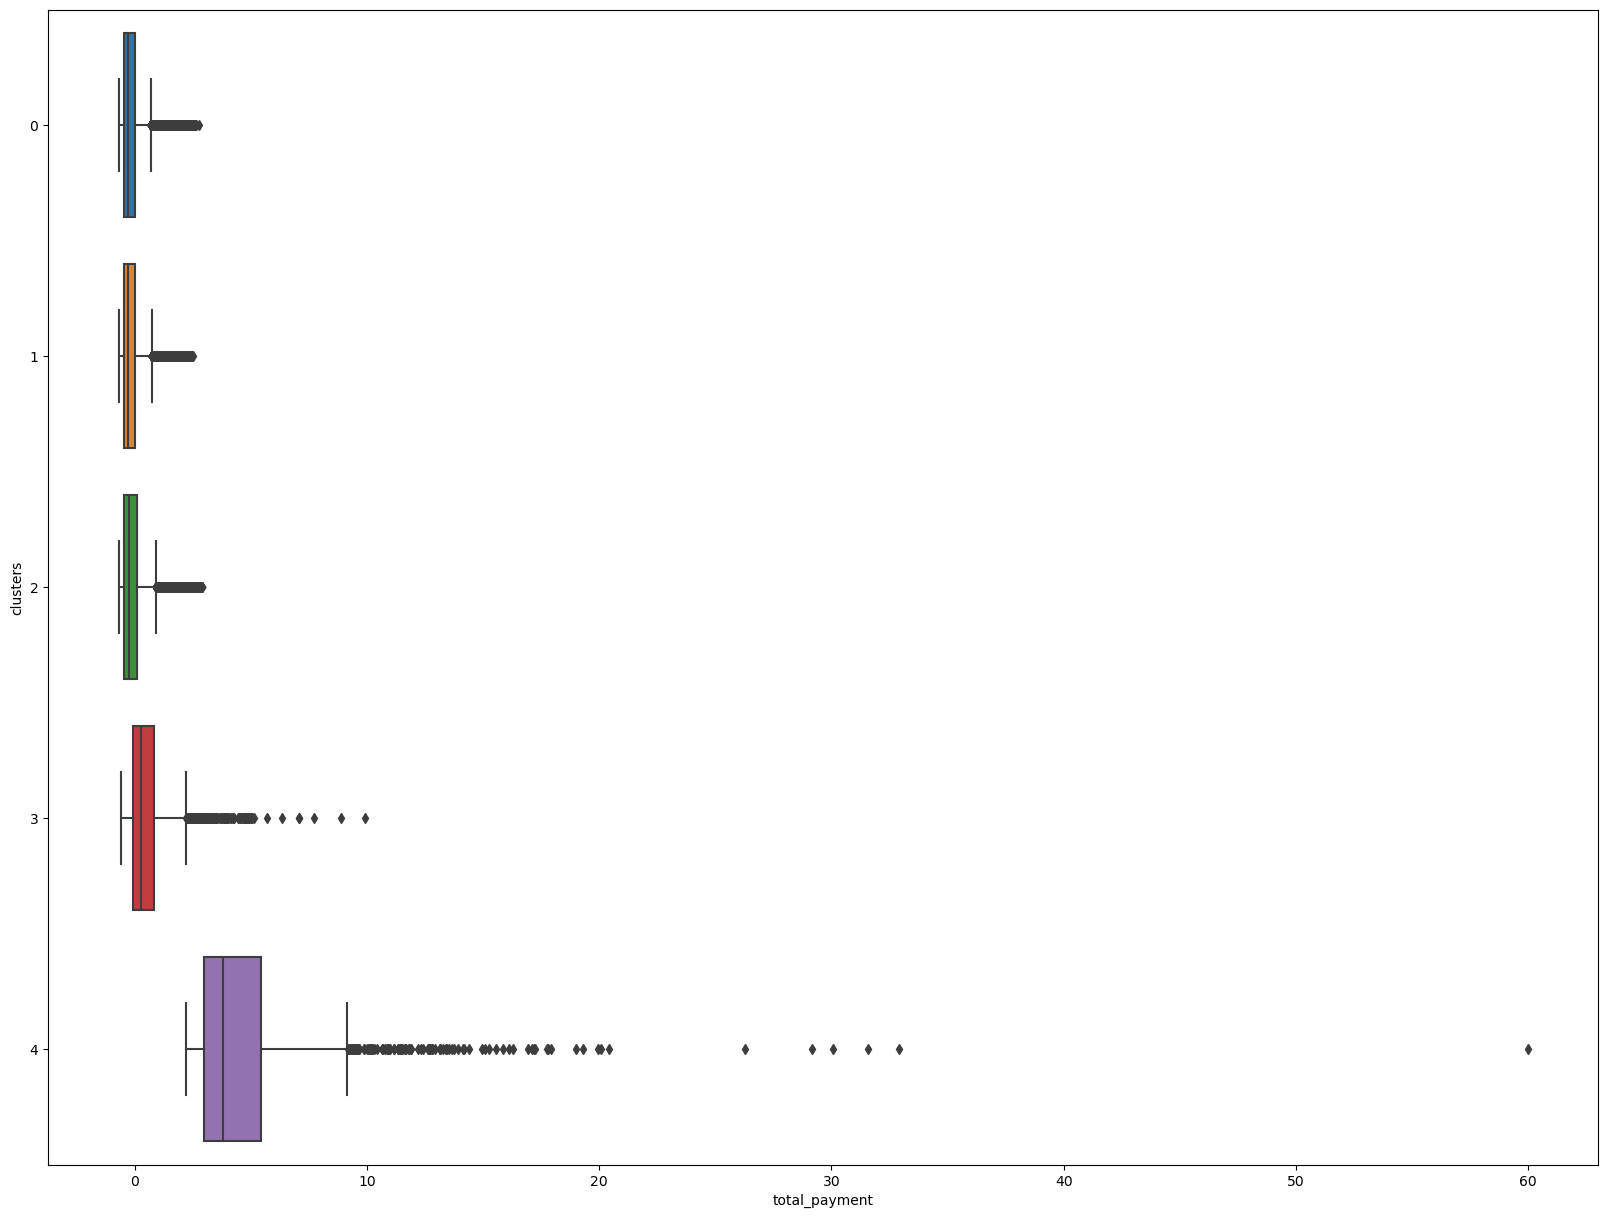

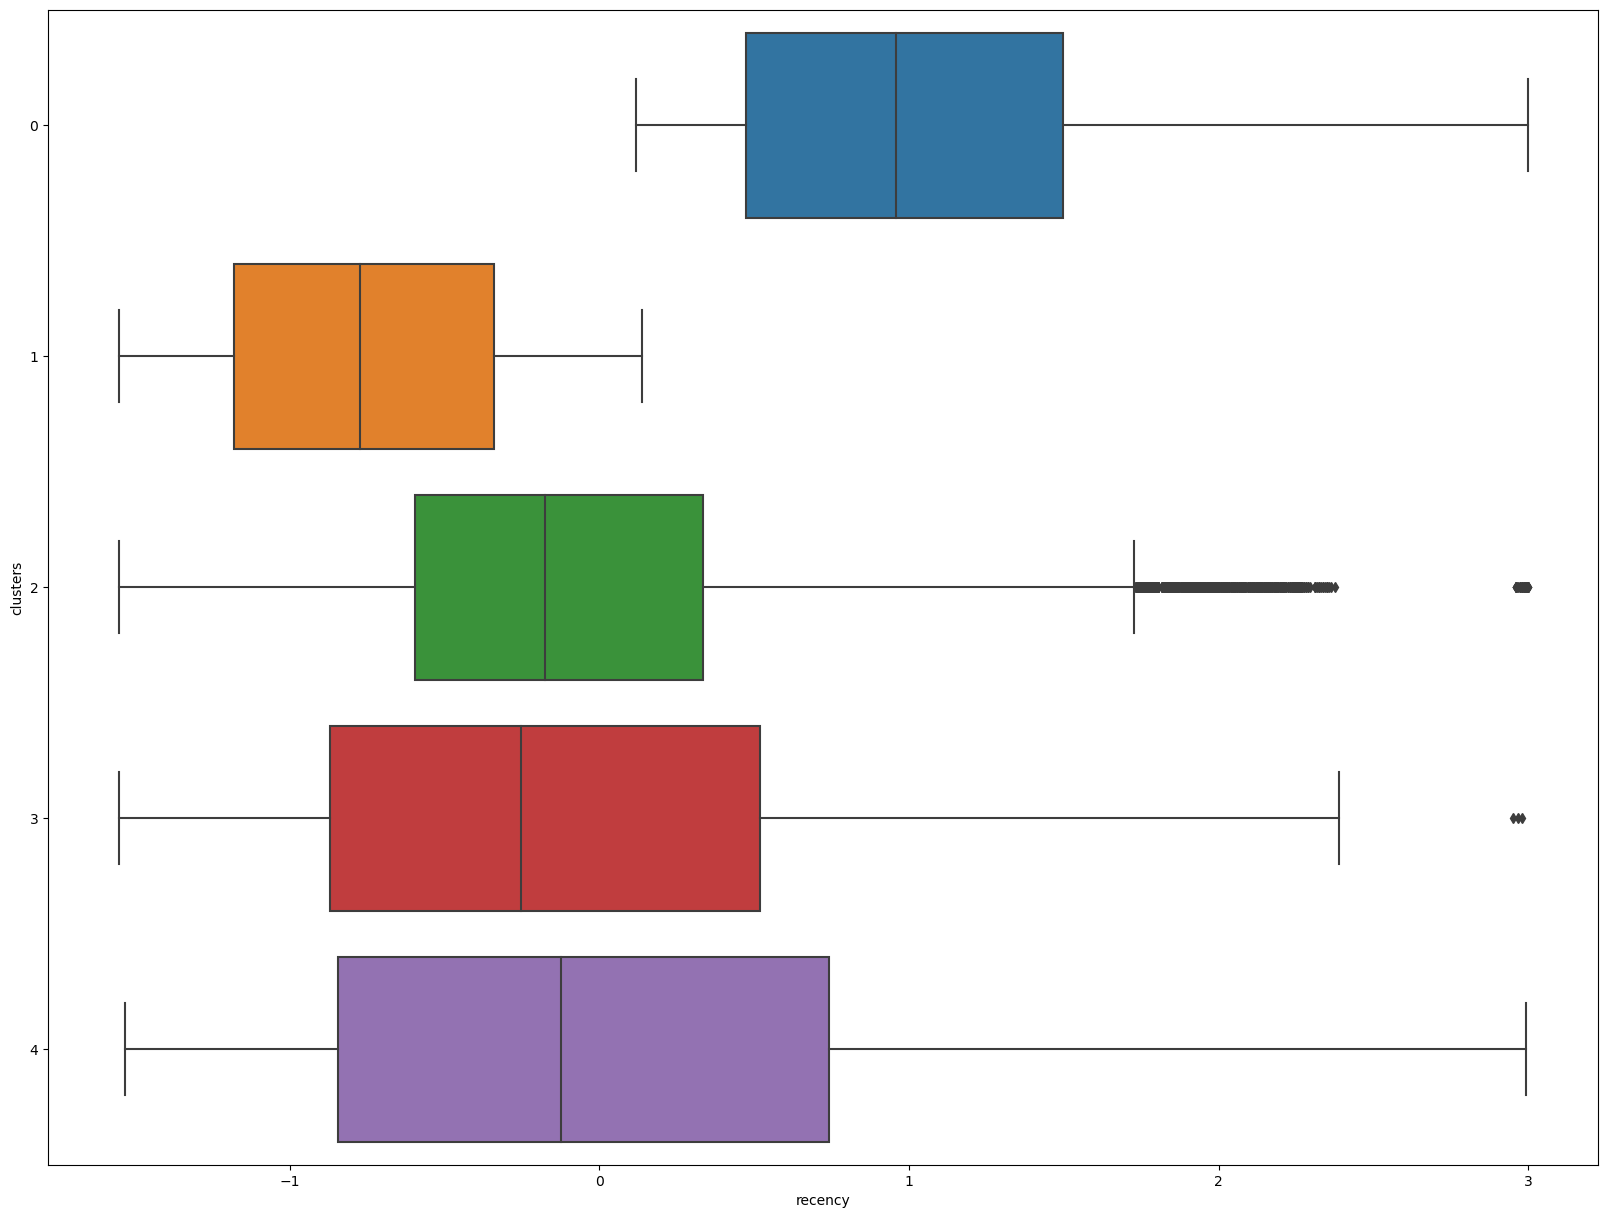

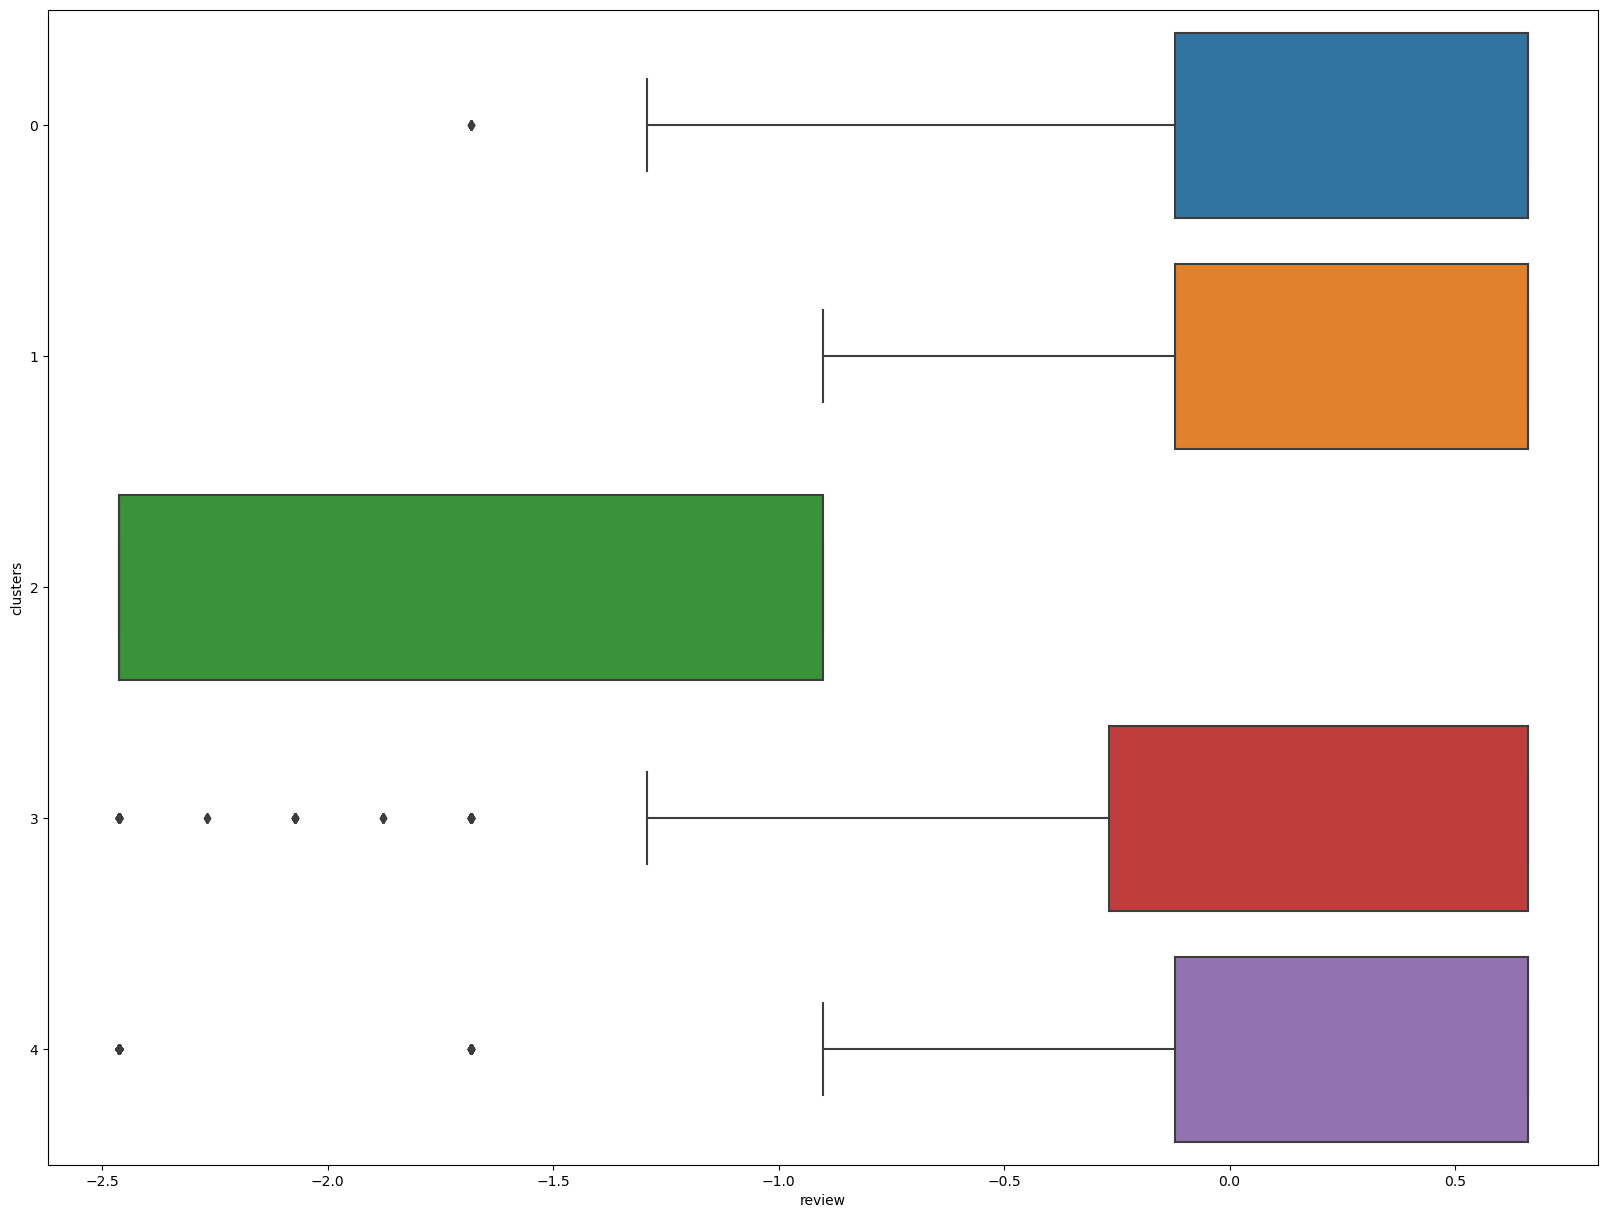

1    41038
0    31233
2    15633
3     2762
4     2066
Name: clusters, dtype: int64


In [12]:
RFM_2.columns=['count','total_payment','recency','review']

clusters_boxplots([5],RFM_2,RFM_2.columns)

Analysons une nouvelle fois nos clusters.
- Cluster 0,1,2 : Clients qui n'ont commandé qu'une fois, pour un montant faible. La différence entre ces 3 clusters est que les 2 premiers suivent encore la répartition récents/anciens clients, et le 3e représente les clients qui ont laissé des mauvaises notes.
- Cluster 3 : Clients réguliers
- Cluster 4 : Clients qui achètent des produits chers

On peut voir que par rapport à la première segmentation, on a un nouveau cluster qui comprend les clients mécontents, et en regardant la répartition des clusters on voit que la majeure partie de ce nouveau cluster provient de l'ancien cluster 1, soit des clients majoritairement anciens.

### RFM + Installments

En plus du review score, on pourrait également considéré l'ajout d'autres features, telle que la quantité d'étalements de paiements sur les commandes.

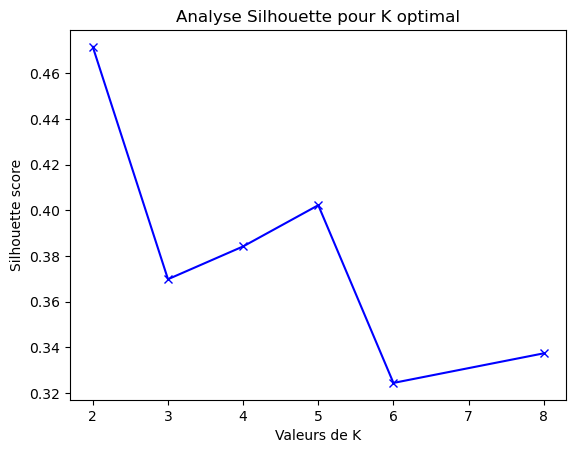

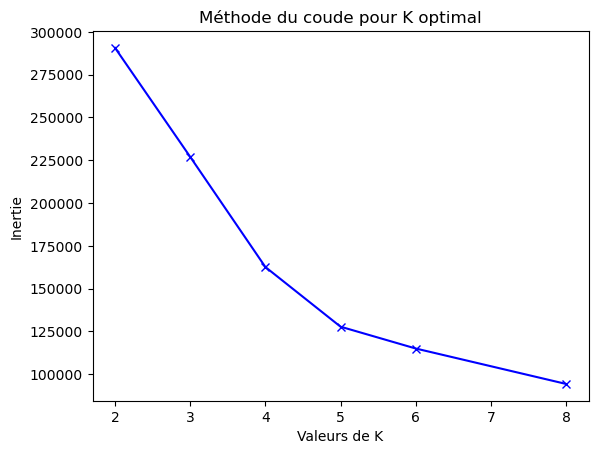

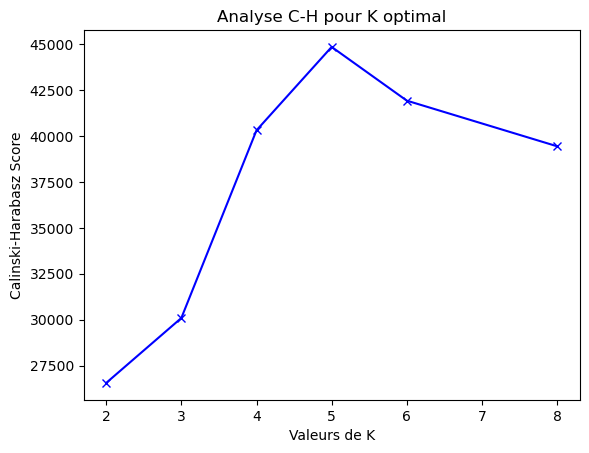

In [13]:
number_k_graphs(RFM_3)

Encore une fois on va considérer 5 clusters.

             count  total_payment   recency  installments
clusters                                                 
0        -0.159817      -0.200946 -0.716830     -0.418284
1        -0.159817       0.339250  0.021271      1.854467
2        -0.159817      -0.203927  1.015001     -0.347794
3         5.169750       0.550063 -0.114578      0.135053
4        -0.069582       5.293237 -0.008557      1.266456


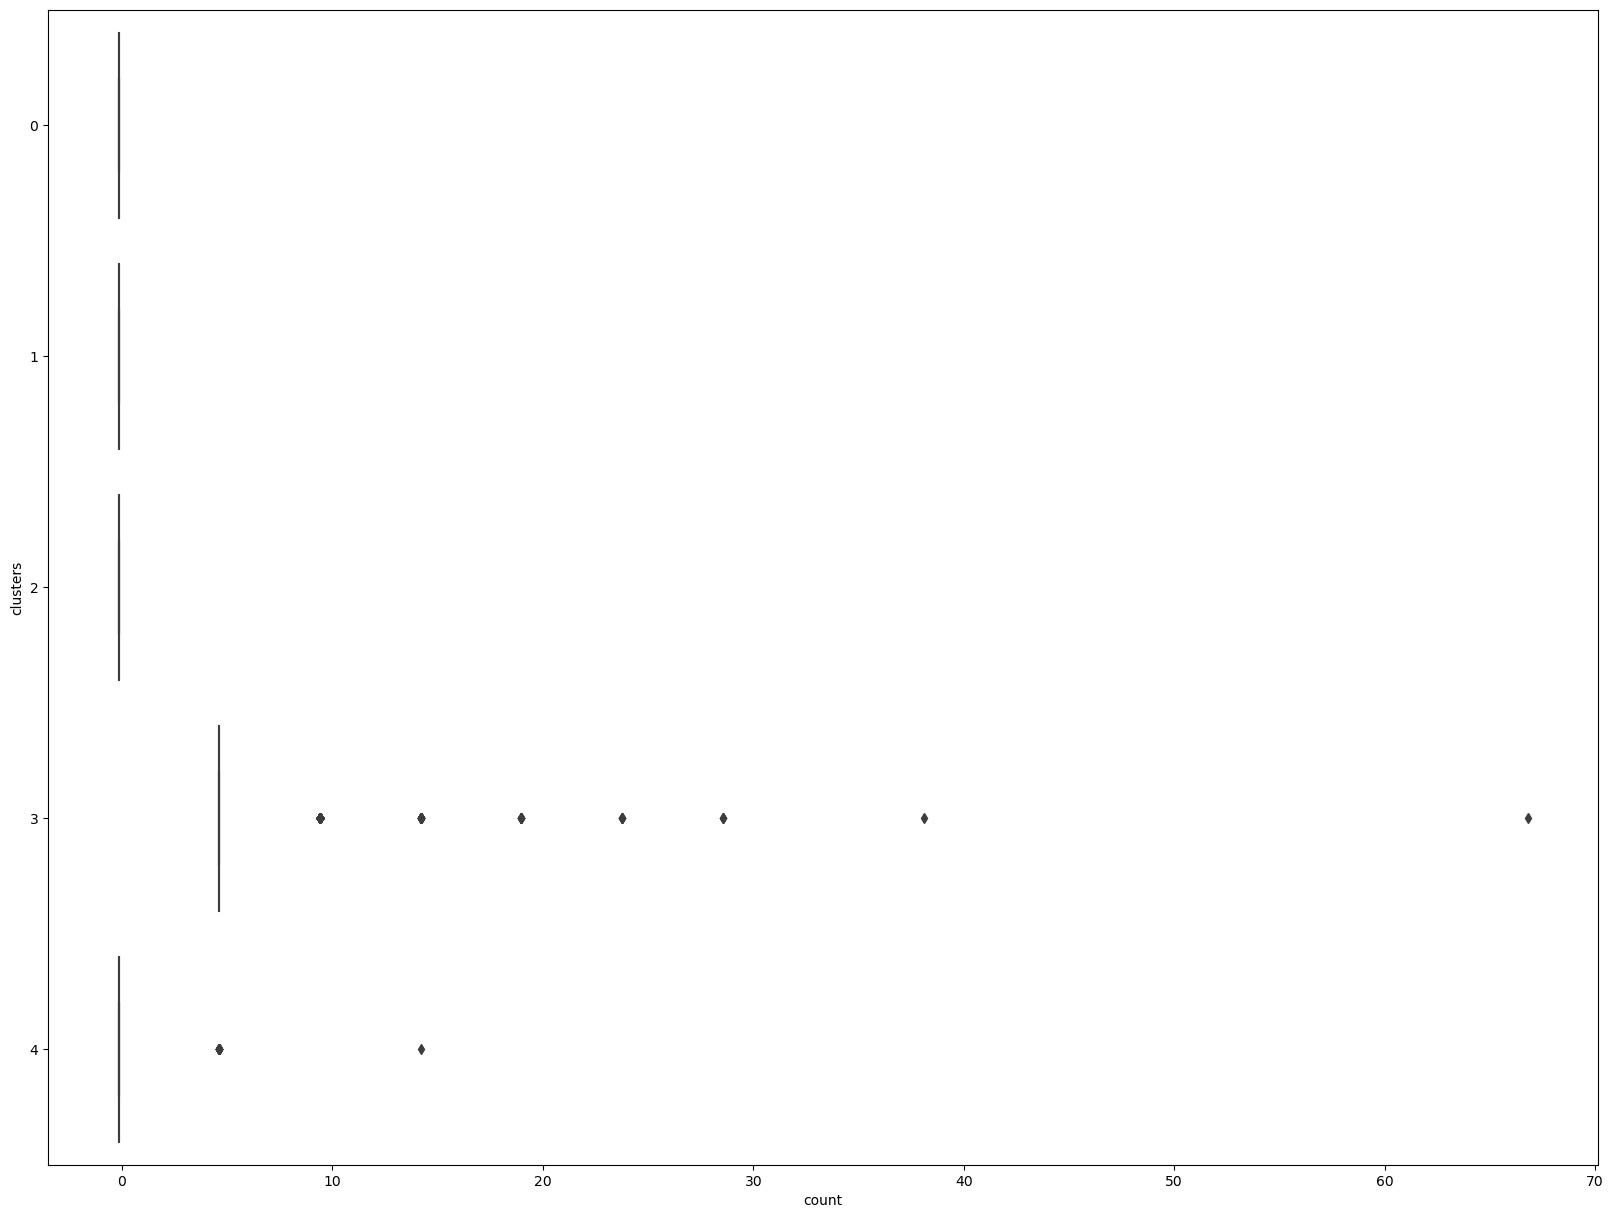

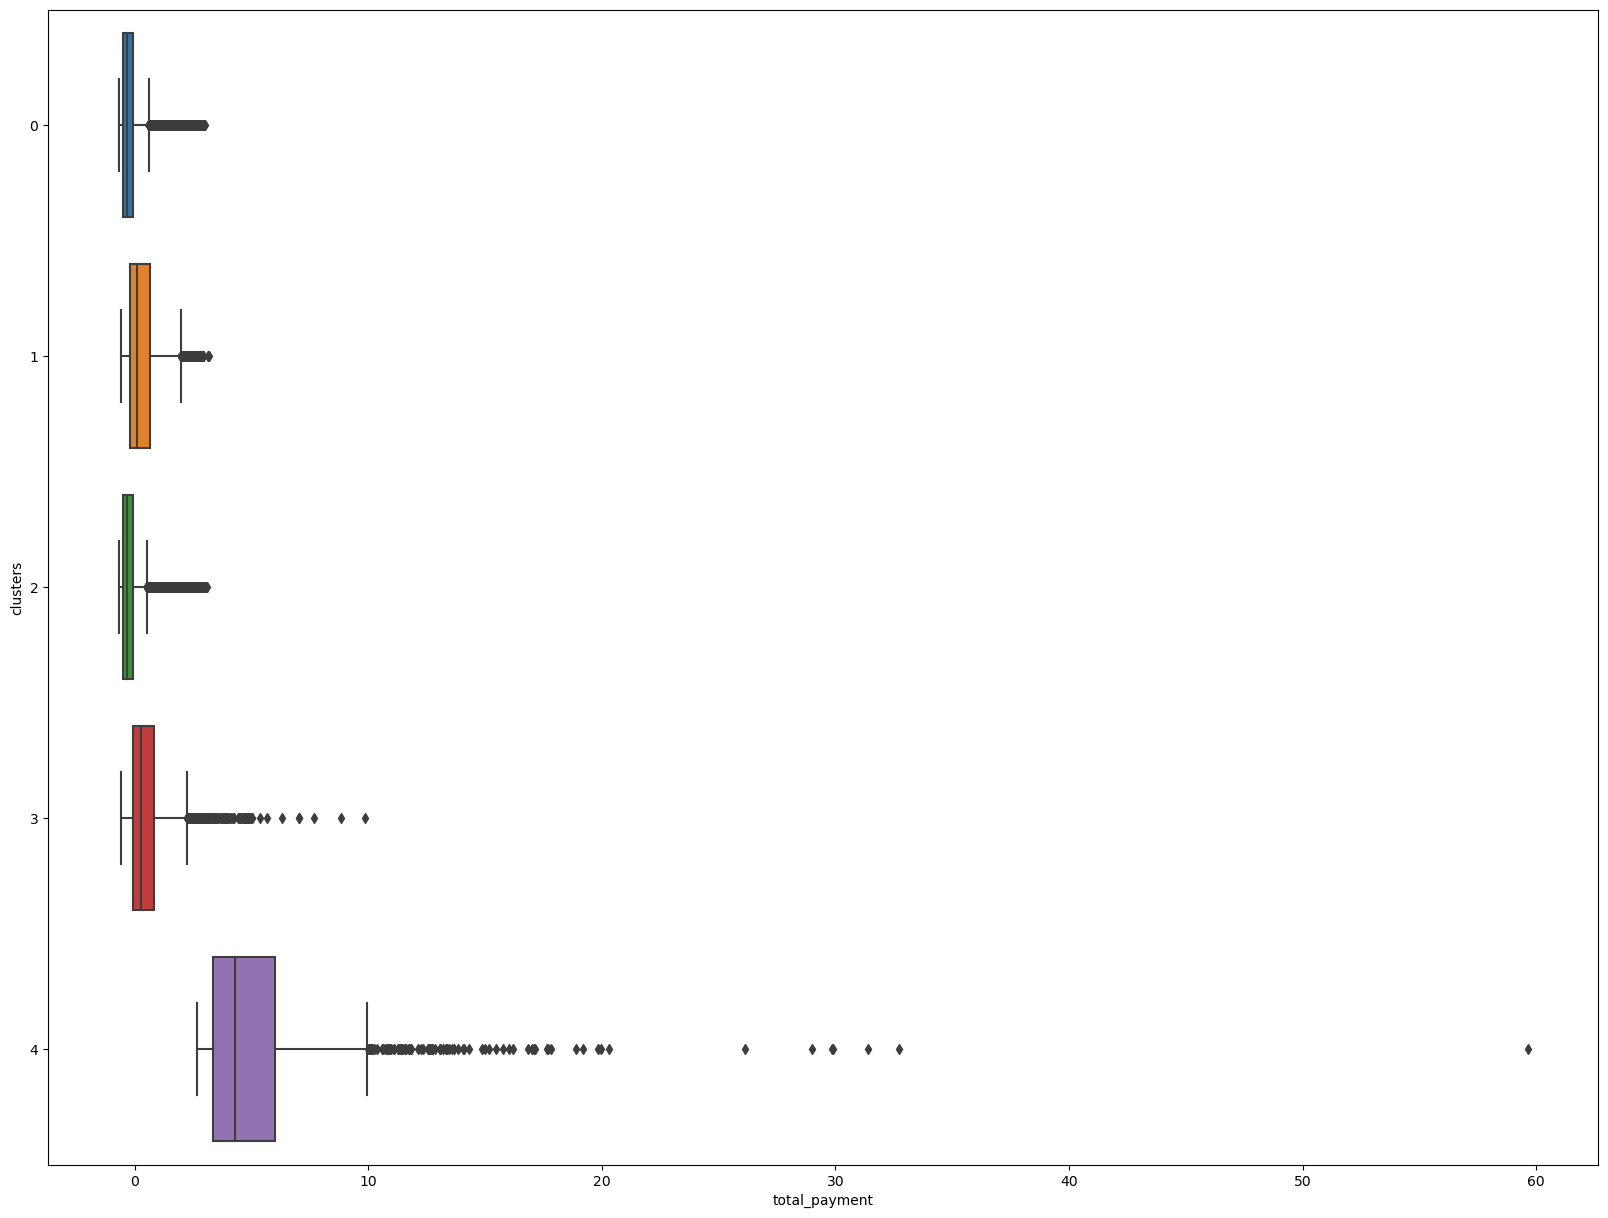

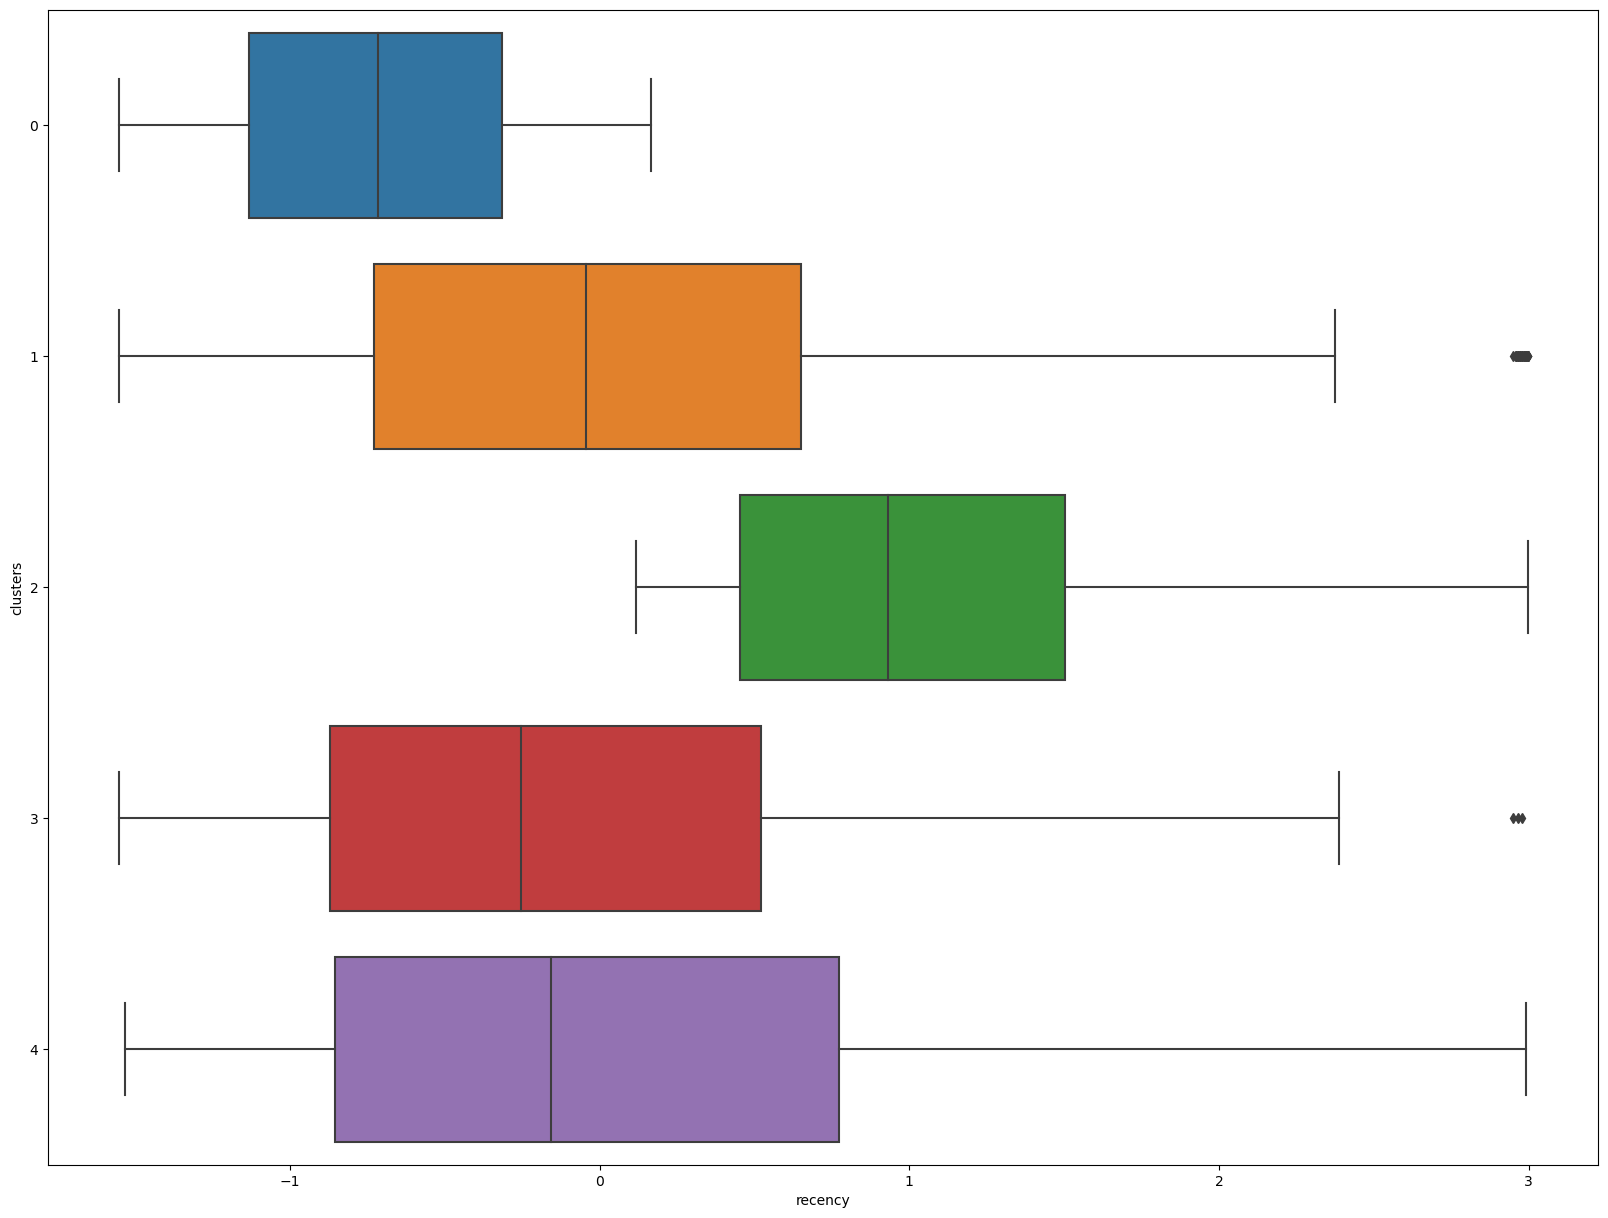

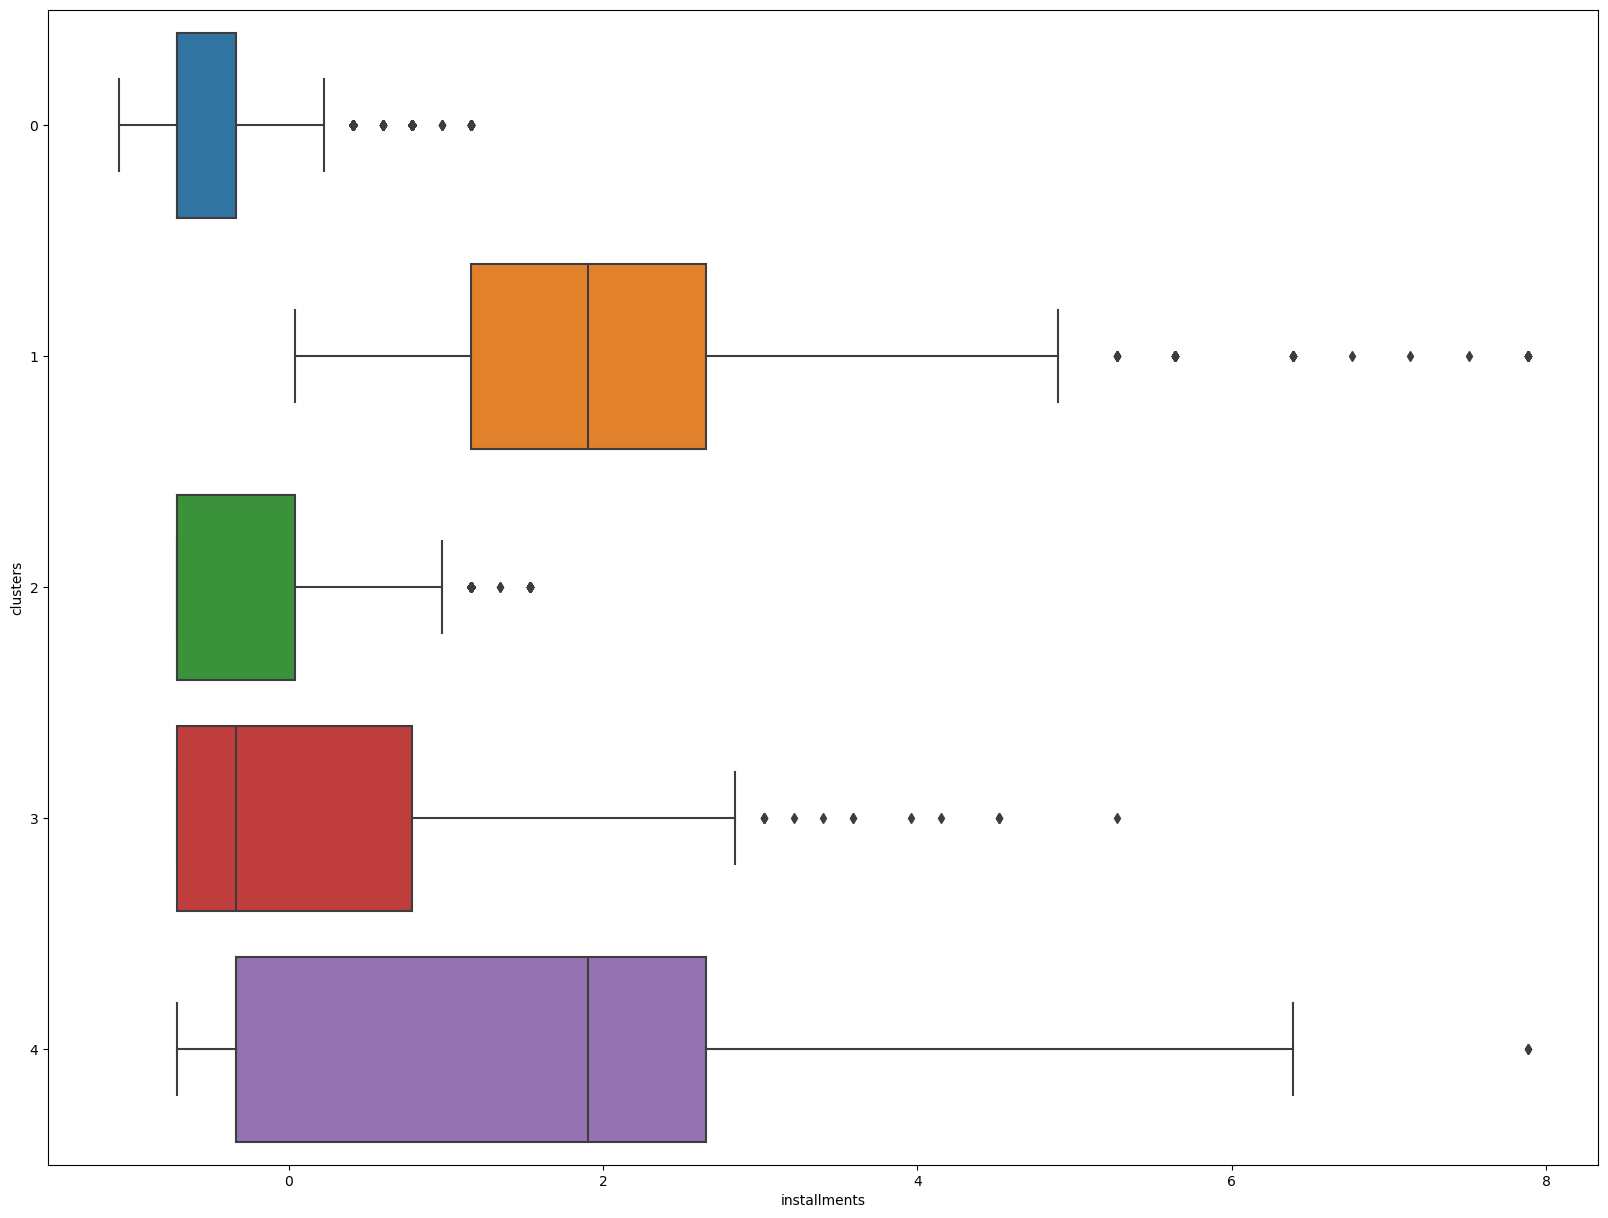

0    43703
2    30891
1    14327
3     2771
4     1643
Name: clusters, dtype: int64


In [14]:
RFM_3.columns=['count','total_payment','recency','installments']

clusters_boxplots([5],RFM_3,RFM_3.columns)

Analysons une nouvelle fois nos clusters.
- Cluster 0,1,2 : Clients qui n'ont commandé qu'une fois, pour un montant faible. La différence entre ces 3 clusters est que les clusters 0 et 2 suivent encore la répartition récents/anciens clients, avec peu d'étalement de paiement, alors que le cluster 1 représente les clients qui étalent généralement leurs paiements.
- Cluster 3 : Clients réguliers, généralement peu d'étalement de paiements.
- Cluster 4 : Clients qui achètent des produits chers, et qui font également beaucoup d'étalement de paiements.

On peut noter que ces différentes segmentations en ajoutant des features apportent des détails intéressants sur nos populations et permettent de différencier plus les clusters. Cependant, elles rendent également le clustering moins efficace, on retrouve en effet de moins bons scores sur nos différentes métriques, comparé à un RFM simple.

## DBScan

Essayons maintenant un autre algorithme que le Kmeans pour le clustering : DBScan. DBScan est un algorithme qui procède directement à la sélection du nombre de clusters optimaux et qui les attribue. Il affecte également au cluster -1 les points qu'il considère comme outliers trop éloignés des autres points. La différence entre Kmeans et DBscan est que là où Kmeans va créer ses clusters en calculant les distances entre les points avec des centroïdes, DBscan lui fait des groupements par densité.

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
dbscan = DBSCAN().fit(RFM_1)

In [19]:
pd.DataFrame(dbscan.labels_).value_counts()

 5     90204
 2      2540
 6       246
 1       161
-1       134
 7         9
 10        7
 0         6
 3         6
 8         6
 11        6
 4         5
 9         5
dtype: int64

On peut voir qu'avec les paramètres de base, le DBScan ne semble pas très bon sur notre problème, on voit en effet 11 clusters extrêment inégaux, avec un cluster unique composé de plus de 90% des points. On peut également évaluer ces clusters avec les scores qu'on a utilisé précédemment.

In [20]:
pd.DataFrame([[silhouette_score(RFM_1, dbscan.labels_),calinski_harabasz_score(RFM_1, dbscan.labels_)]],columns=['Silhouette','Calinski'])


,Silhouette,Calinski
0,0.47177,4284.256777


Encore une fois, même si le score Silhouette est assez bon, on peut voir que le Calinski est extrêmement bas, sûrement à cause de la mauvaise répartition des clusters. On peut maintenant essayer de faire varier les paramètres afin d'essayer d'obtenir des meilleurs résultats.

In [21]:
for i in [0.1,0.5,0.8] :
    dbscan = DBSCAN(eps=i,n_jobs=5).fit(RFM_1)
    print('EPS =' + str(i))
    print(pd.DataFrame(dbscan.labels_).value_counts())
    print(pd.DataFrame([[silhouette_score(RFM_1, dbscan.labels_),calinski_harabasz_score(RFM_1, dbscan.labels_)]],columns=['Silhouette','Calinski']))
    print('---------------------------------------------------------')

EPS =0.1
 17    89232
 1      2109
-1      1248
 19      225
 31       24
       ...  
 12        5
 15        5
 40        5
 36        5
 60        5
Length: 62, dtype: int64
   Silhouette    Calinski
0    0.393308  913.670137
---------------------------------------------------------
EPS =0.5
 5     90204
 2      2540
 6       246
 1       161
-1       134
 7         9
 10        7
 0         6
 3         6
 8         6
 11        6
 4         5
 9         5
dtype: int64
   Silhouette     Calinski
0     0.47177  4284.256777
---------------------------------------------------------
EPS =0.8
 5    90499
 4     2561
 2      170
-1       64
 1       19
 6        7
 0        5
 3        5
 7        5
dtype: int64
   Silhouette     Calinski
0    0.709028  6089.173251
---------------------------------------------------------


In [22]:
dbscan = DBSCAN(eps=0.95,n_jobs=-1).fit(RFM_1)

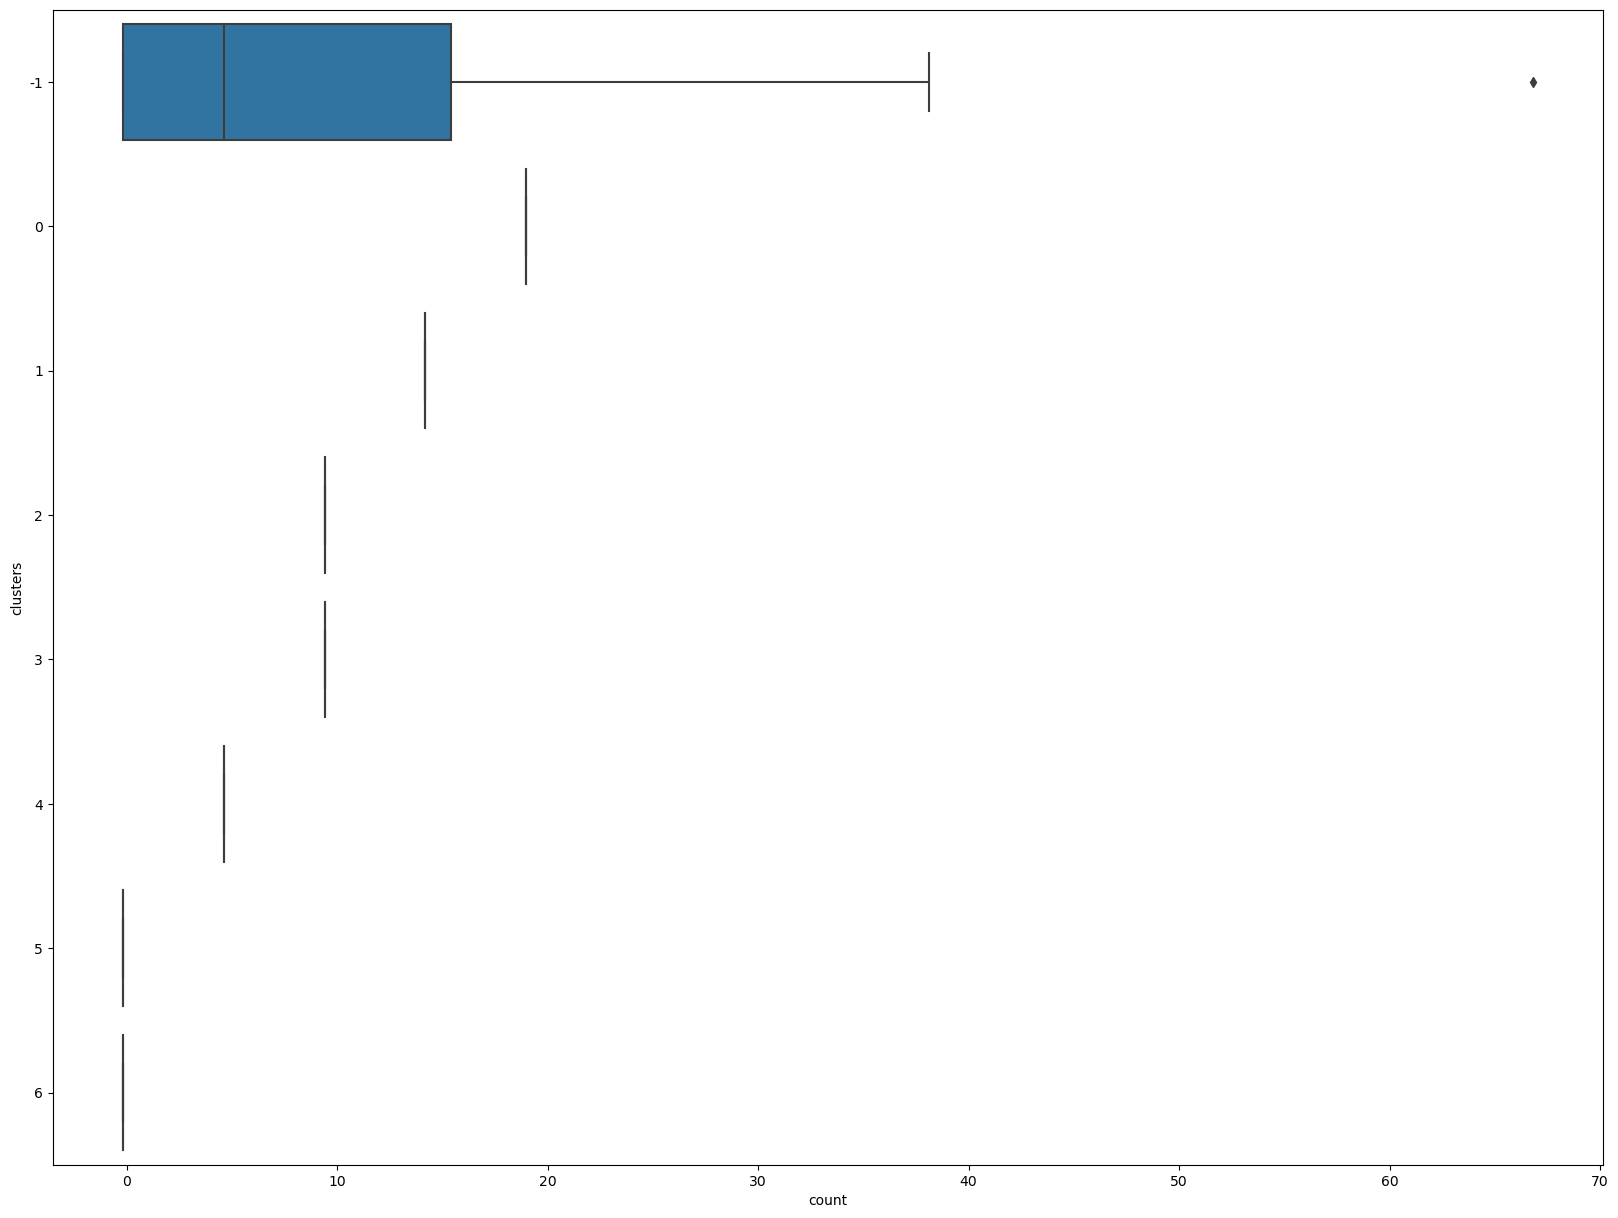

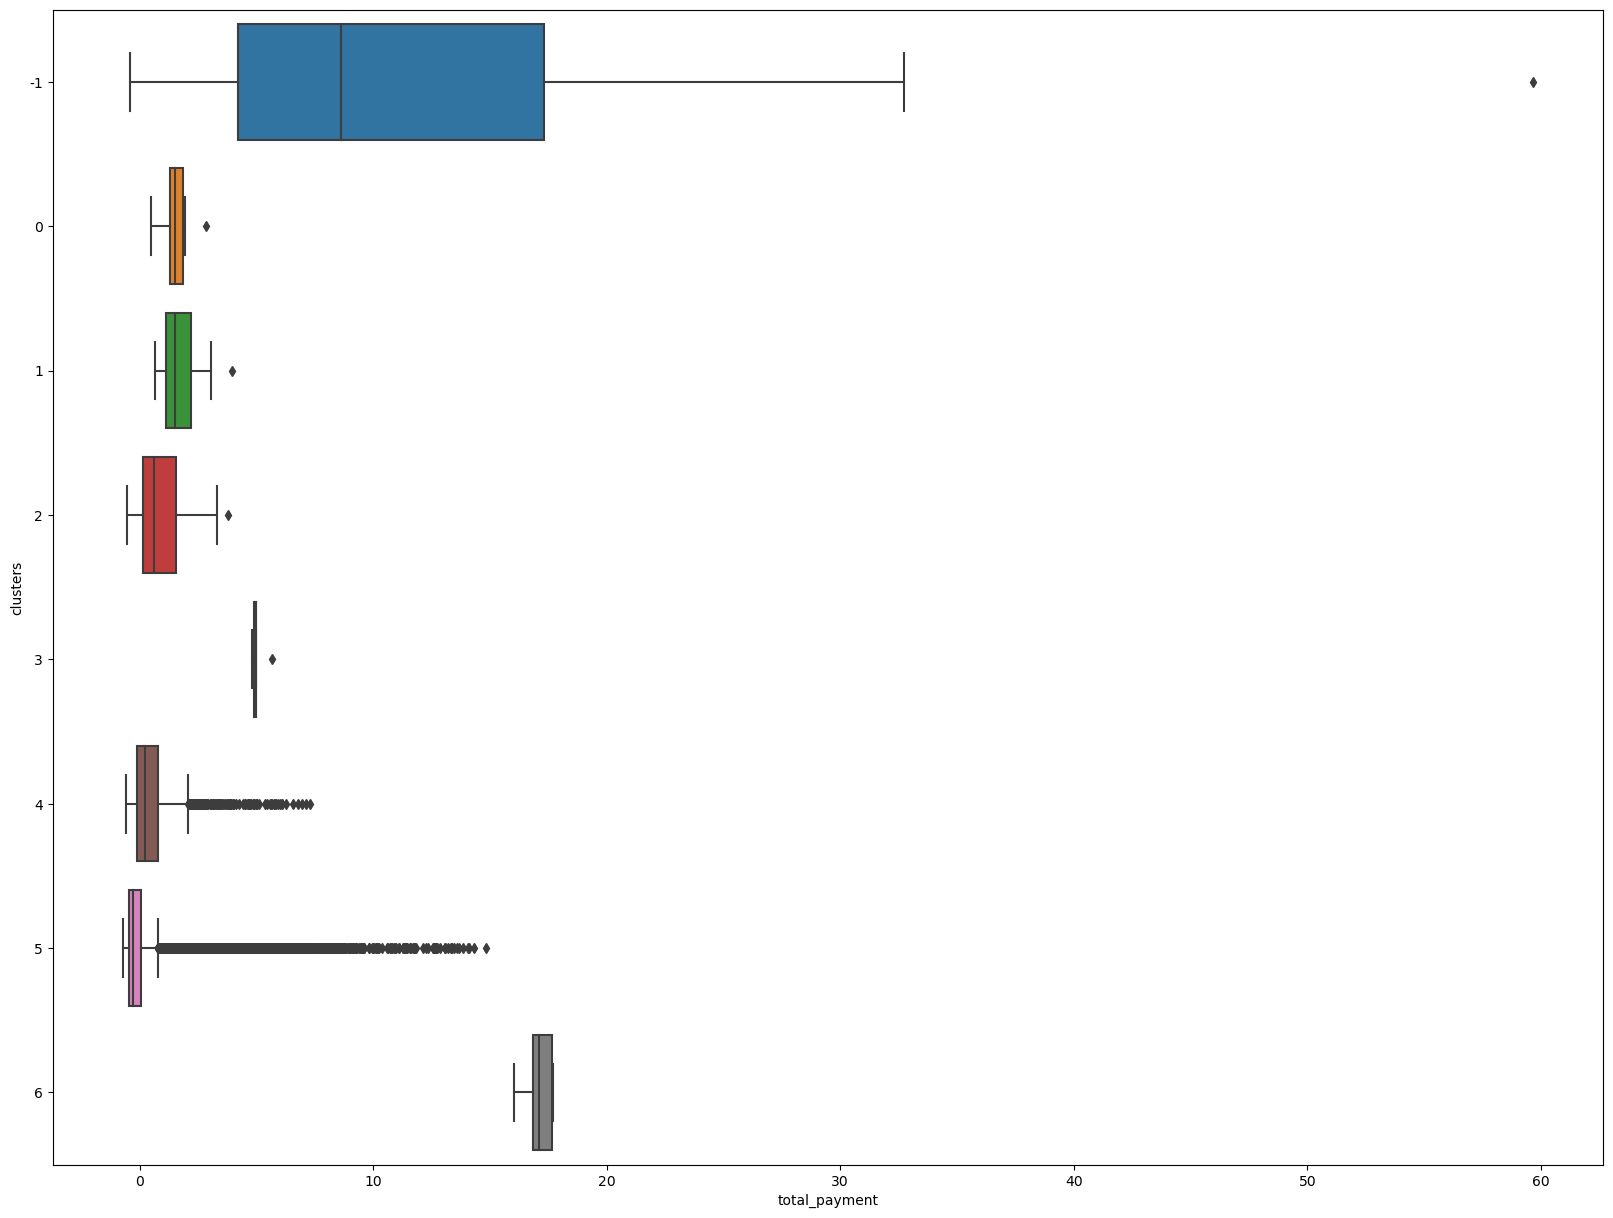

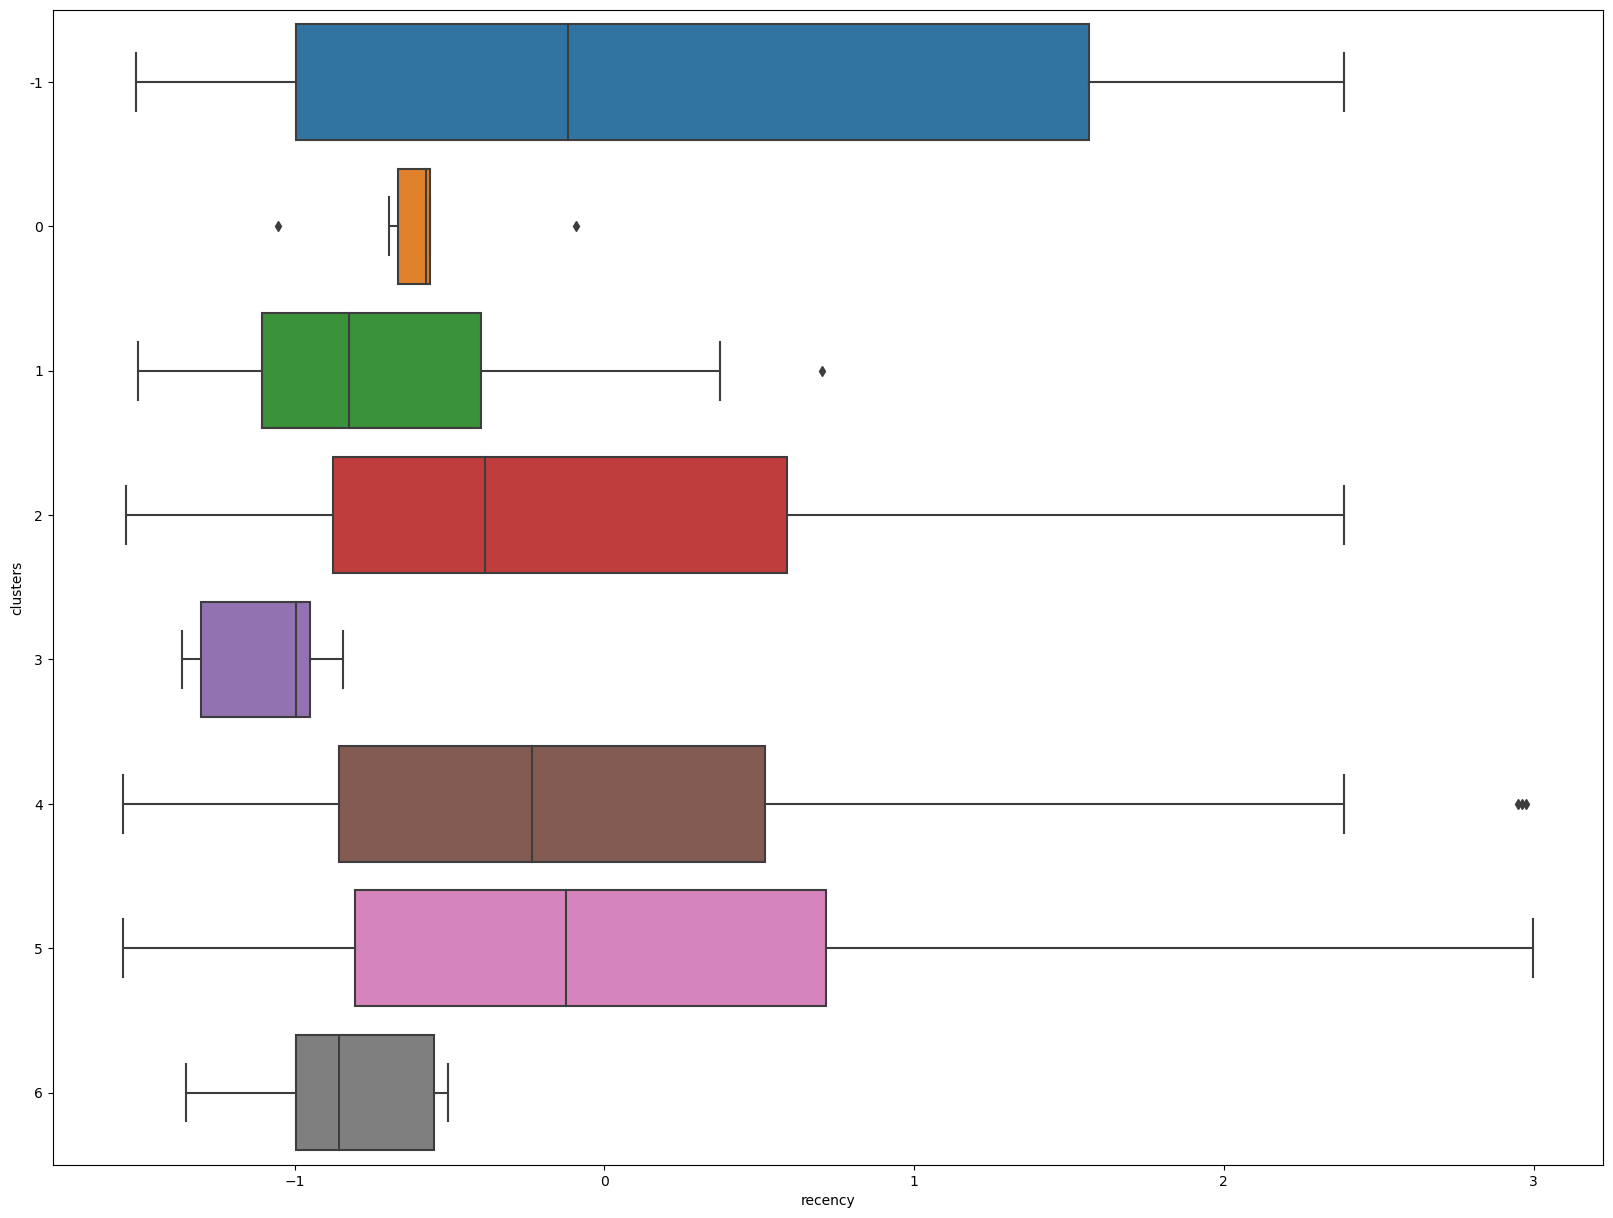

In [23]:
clust = pd.concat([RFM_1,pd.Series(dbscan.labels_)],axis=1)

columns=['count','total_payment','recency']

clust.rename({0:'clusters'},axis=1,inplace=True)
clust['clusters'] = clust['clusters'].astype('category')

rcParams['figure.figsize'] = 20,15
for column in columns :
    sns.boxplot(data=clust,y='clusters',x=column)
    plt.show()

In [65]:
qpop = clust.clusters.value_counts()
qpop

5     90513
4      2562
2       171
-1       52
1        21
0         6
3         5
6         5
Name: clusters, dtype: int64

<AxesSubplot:>

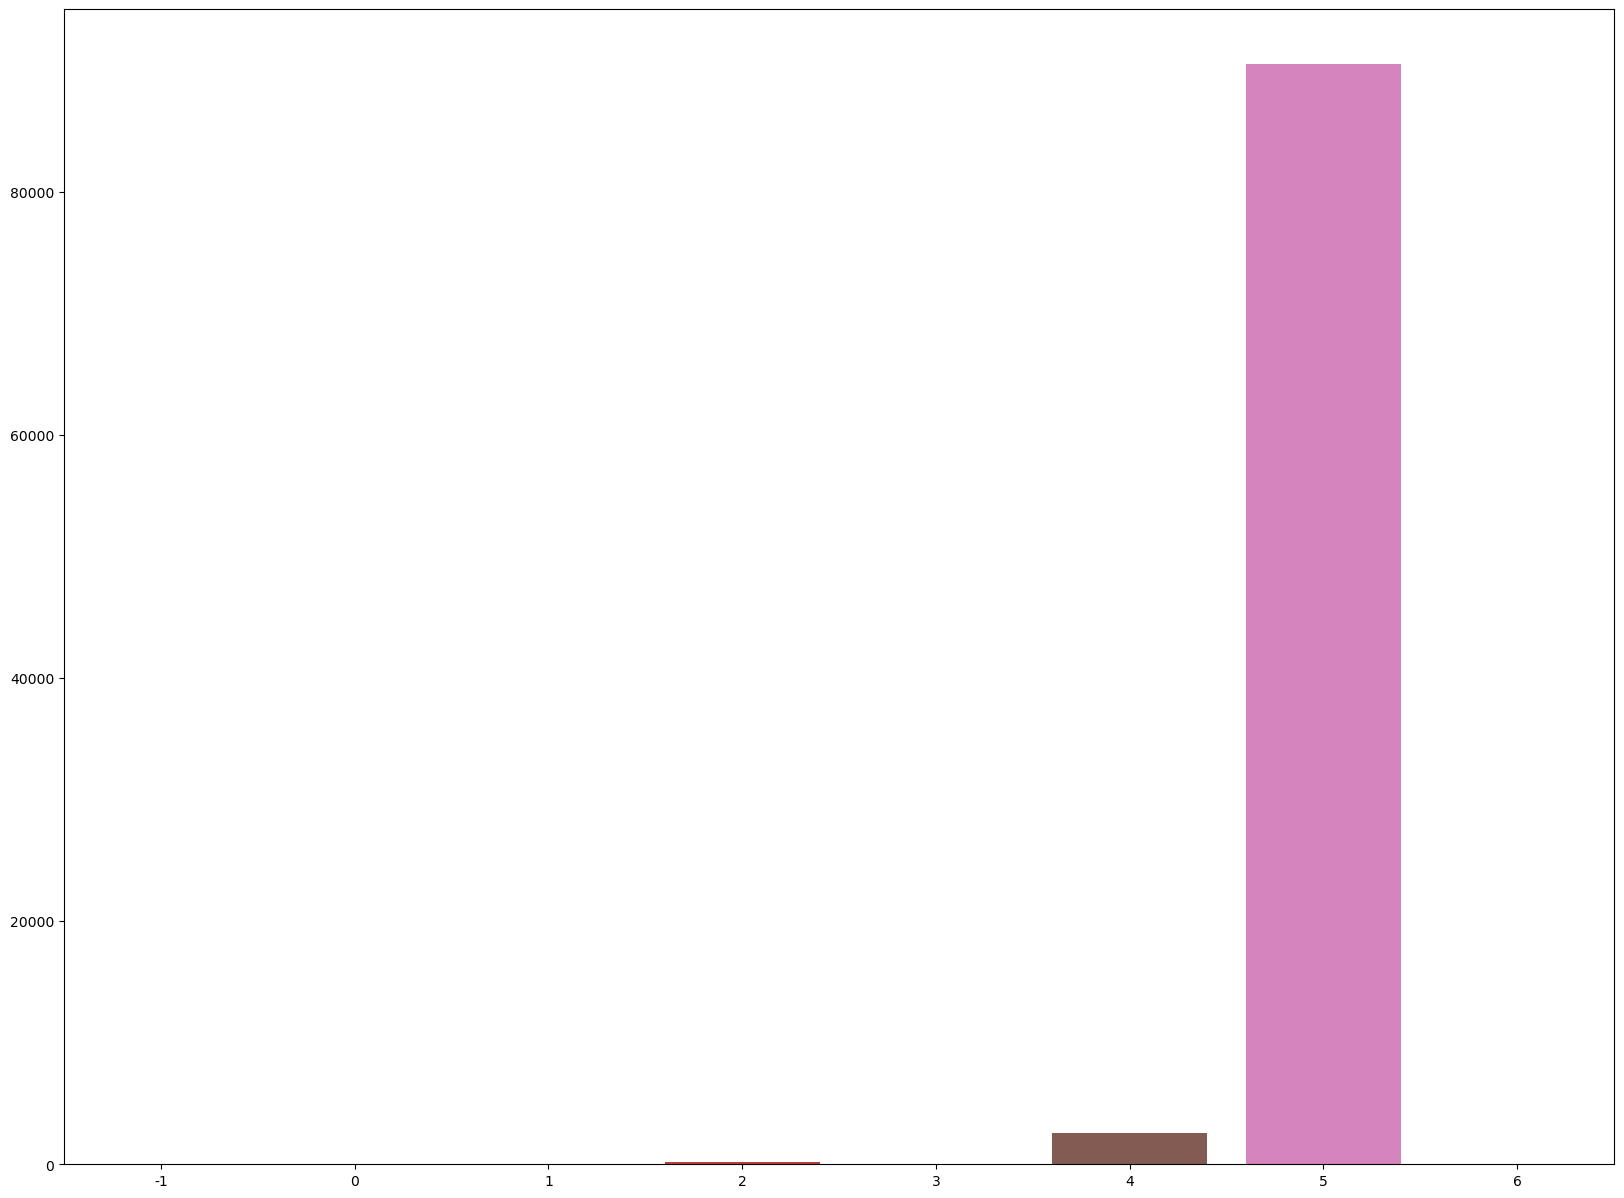

In [66]:
sns.barplot(x=qpop.index,y=qpop.values)

Avec la taille de notre dataset, il n'est pas possible de continuer à augmenter eps car la charge de mémoire est trop élevée. On voit cependant qu'augmenter l'eps fait chuter le nombre de clusters et vient également sensiblement augmenter le silhouette score. Malheureusement, la répartition de la population est encore une fois très mauvaise, avec certains clusters qui sont quasiment vides, et toujours un très mauvais score Calinski-Harabasz.

De plus comme on le voit sur nos boxplots, le nombre élevé de clusters déterminé par l'algorithme rend plus difficile l'explication de ces différents clusters, avec des clusters concentrés sur très peu de points.

## Hierarchical Clustering

Une autre méthode segmentation serait le hierarchical clustering. On va ici utiliser AgglomerativeClustering, qui regroupe les points similaires en clusters de plus en plus gros jusqu'à tout regrouper. On va ensuite pouvoir visualiser le résultat à l'aide d'un dendrogramme.

Le problème de ce modèle est qu'il consomme beaucoup de mémoire, et pour pouvoir l'appliquer à notre dataset on va donc devoir prendre seulement un échantillon de ce dernier afin d'obtenir des résultats intéressants.

In [8]:
sample = RFM_1.groupby('count',group_keys=False).apply(lambda x : x.sample(frac=0.1,random_state=10))
sample

,count,total_payment,recency
41888,-0.159817,-0.637330,1.954186
26468,-0.159817,-0.466919,-0.032113
22449,-0.159817,-0.618155,-1.107206
58502,-0.159817,-0.211324,-1.389090
73882,-0.159817,-0.167407,-0.674547
...,...,...,...
125,9.405098,0.479379,-0.110779
26,14.187556,2.712709,-1.067873
40,14.187556,2.092345,-0.399218
24,14.187556,0.644798,-0.989208


In [9]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4,compute_distances=True).fit(sample)

In [10]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

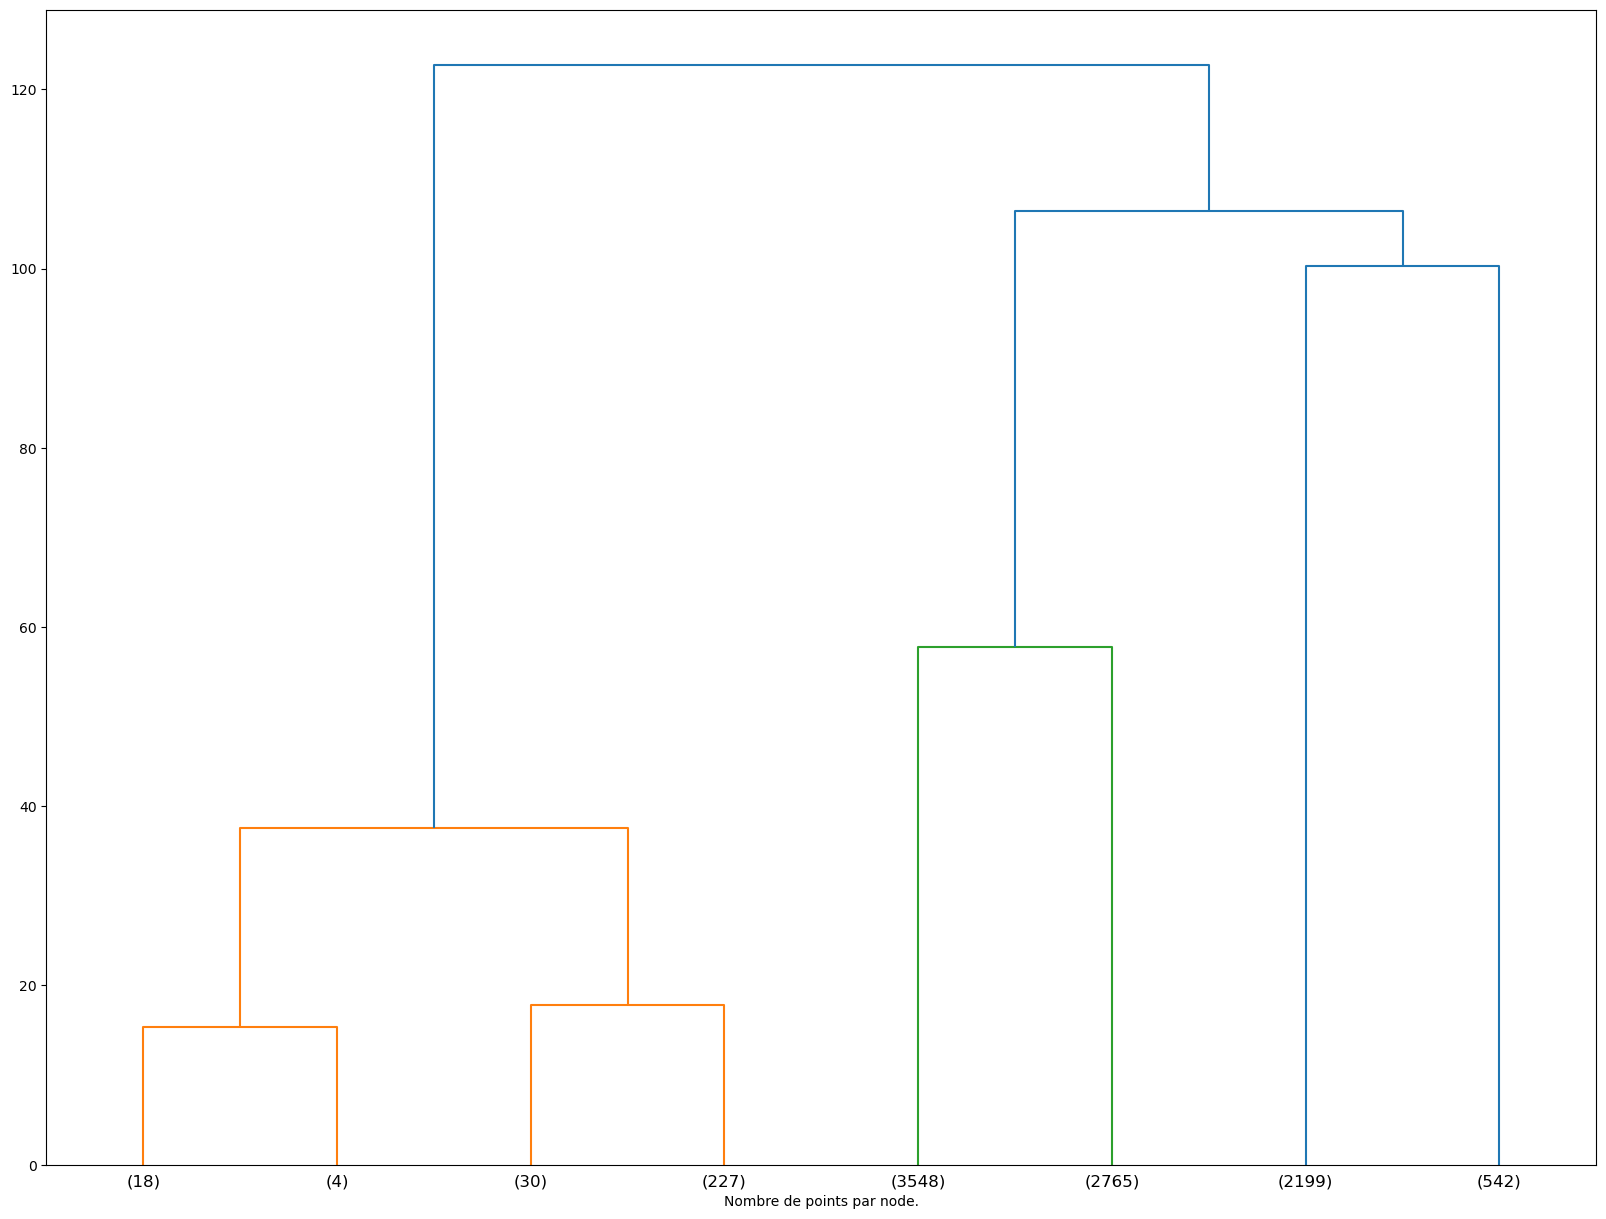

In [27]:
from scipy.cluster.hierarchy import dendrogram

plot_dendrogram(clustering, truncate_mode="level", p=2)
plt.xlabel("Nombre de points par node.")
plt.show()

In [12]:
pd.DataFrame(clustering.labels_).value_counts()

2    6313
3    2199
0     542
1     279
dtype: int64

La répartition est ici meilleure que sur le DBscan, et proportionnellement assez proche du résultat obtenu avec le Kmeans.

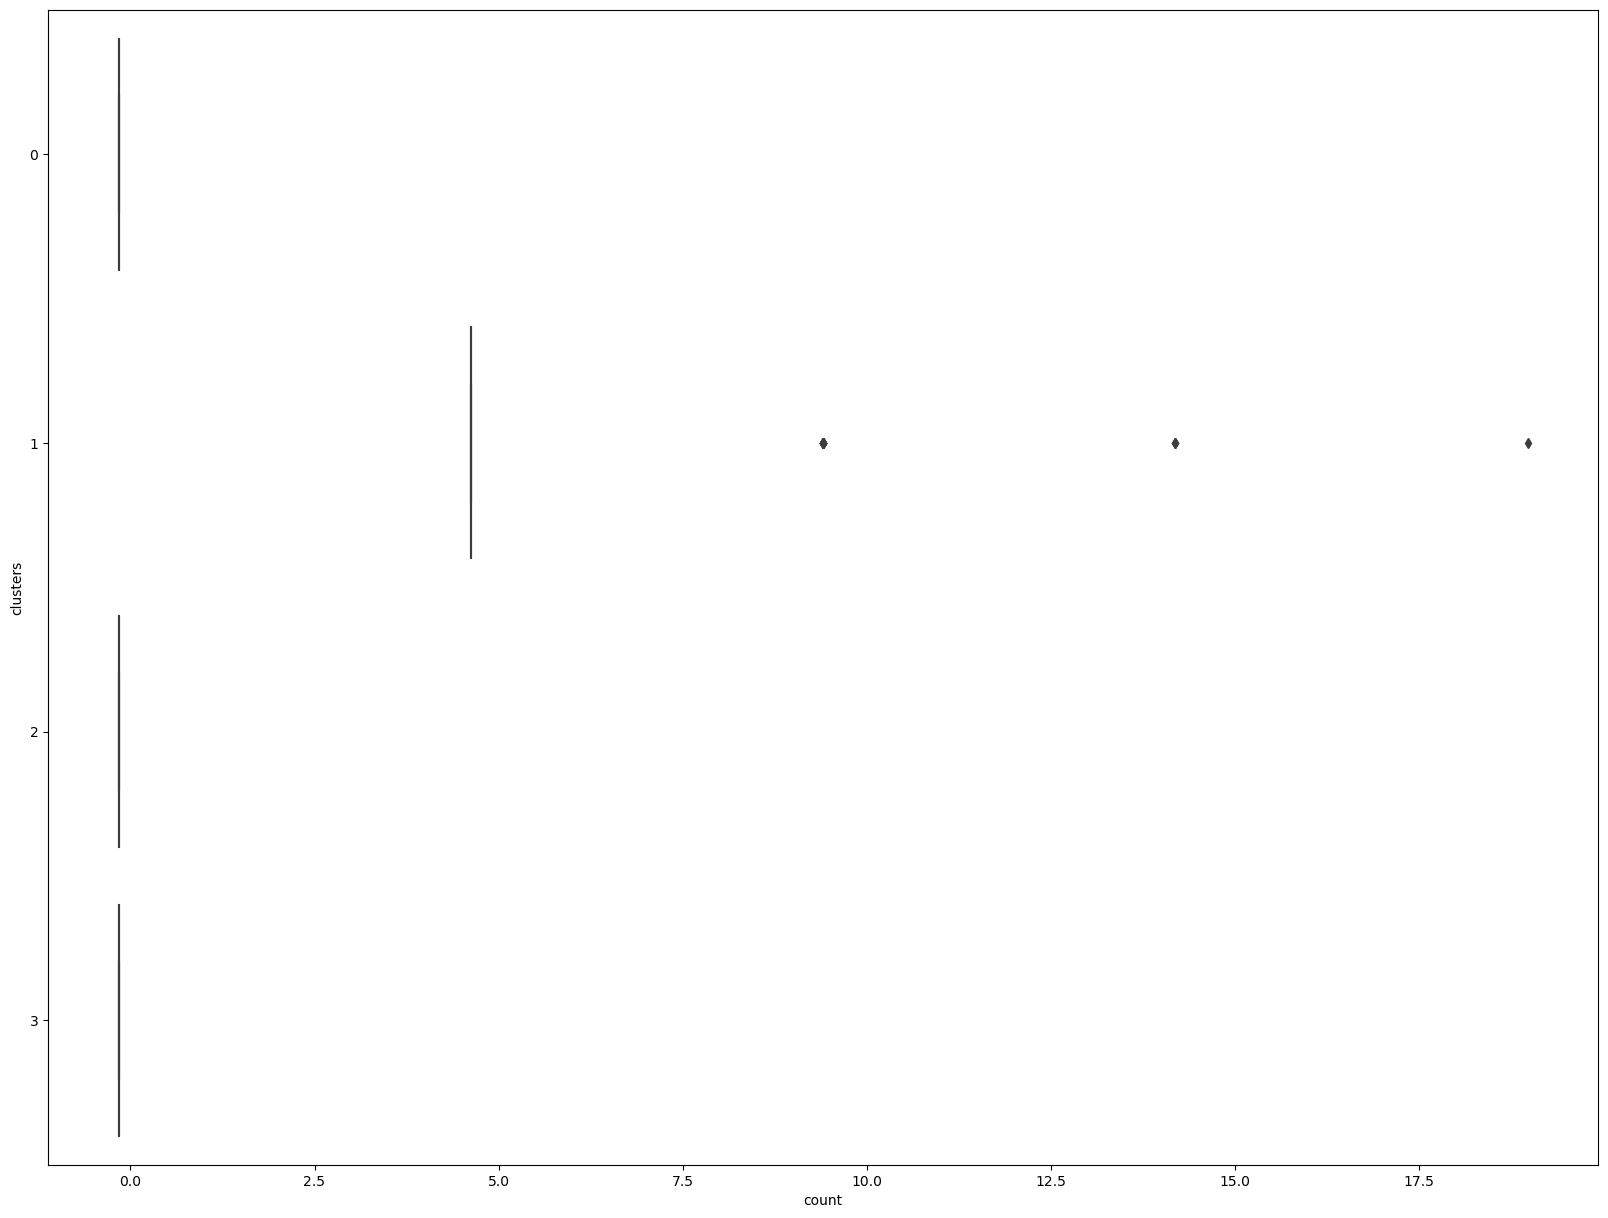

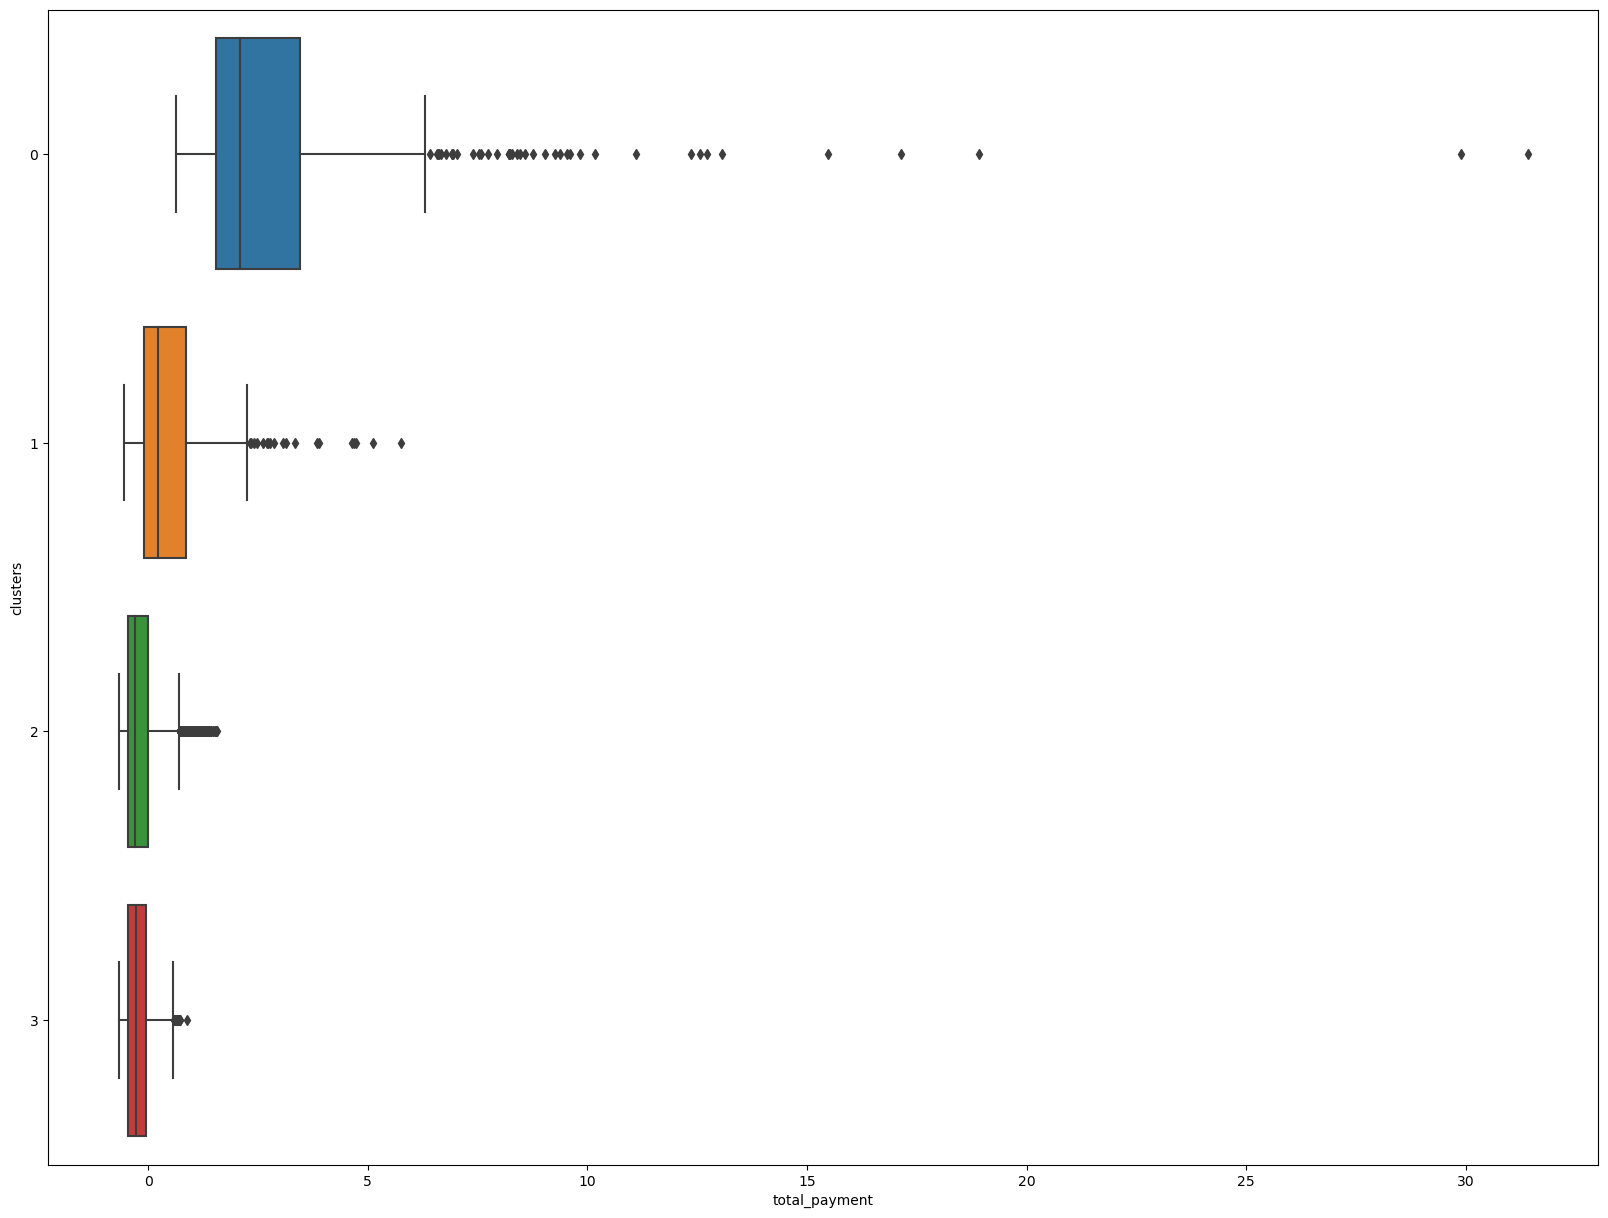

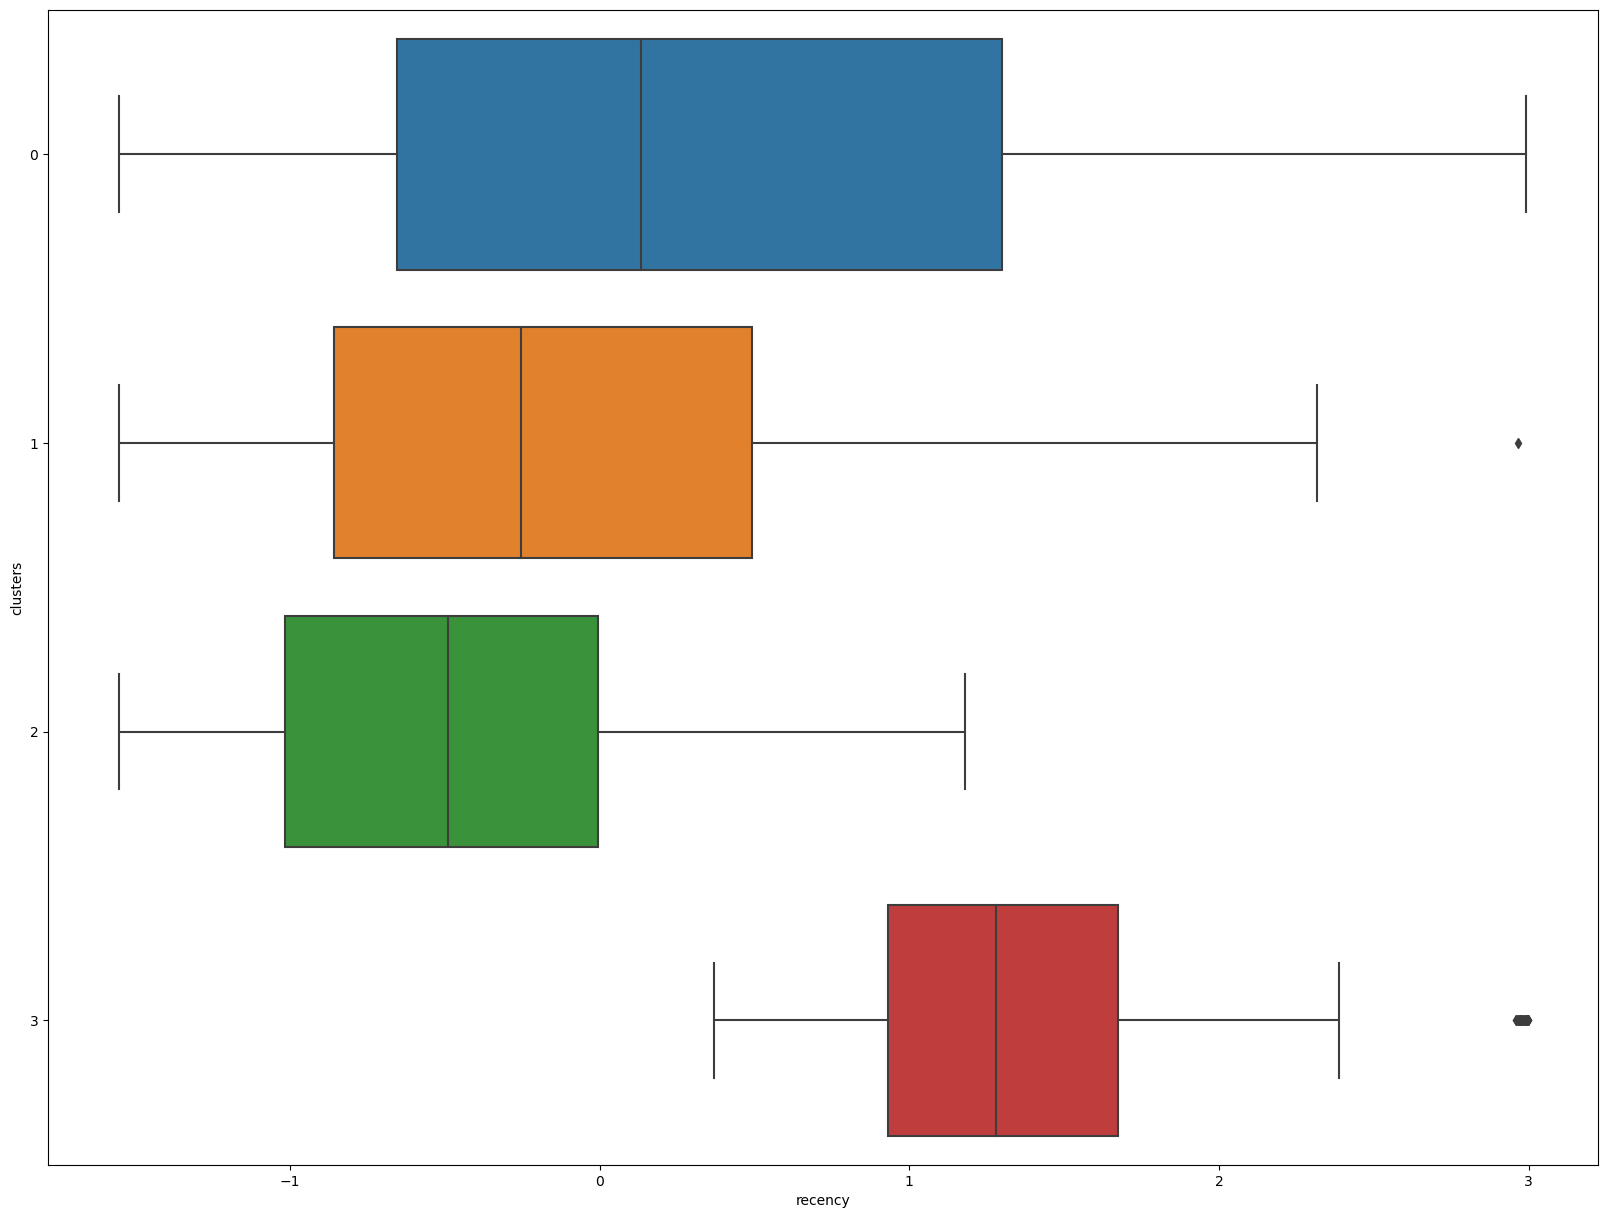

In [13]:
sample.reset_index(inplace=True,drop=True)
clust = pd.concat([sample,pd.Series(clustering.labels_)],axis=1)

columns=['count','total_payment','recency']

clust.rename({0:'clusters'},axis=1,inplace=True)
clust['clusters'] = clust['clusters'].astype('category')

rcParams['figure.figsize'] = 20,15
for column in columns :
    sns.boxplot(data=clust,y='clusters',x=column)
    plt.show()

In [ ]:
pd.DataFrame([[silhouette_score(sample, clustering.labels_),calinski_harabasz_score(sample, clustering.labels_)]],columns=['Silhouette','Calinski'])

On retrouve ici une nouvelle fois un score Silhouette correct, mais un score Calinski vraiment très bas par rapport aux résultats obtenus avec le Kmeans, alors que la répartition des clusters est très semblable à celle obtenue précédemment. De plus, le fait de ne pas pouvoir traiter tout le dataset par manque de mémoire pose problème donc ce modèle n'est pas très pertinent.

## Analyse des Populations

Grâce à nos différents regroupements en clusters, on a pu séparé notre population en différents groupes. Il serait intéressant de regarder plus en détails ces différents groupes afin d'en étudier les caractéristiques (autres que celles qu'on a utilisé pour le clustering) au sein de ces clusters afin de voir si c'est tendances se dégagent.

On va étudier cela simplement avec uniquement le RFM.

In [28]:
#On importe le RFM simple pour garder les customer_unique_id en index
RFM = pd.read_csv('RFM.csv')
RFM.index = RFM['customer_unique_id']
RFM.drop('customer_unique_id', axis=1, inplace=True)

#On réimporte les fichiers originaux
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')

#On garde de nouveau uniquement les commandes livrées.
orders = orders.loc[orders['order_status']=='delivered']
customers = customers.loc[customers['customer_id'].isin(orders['customer_id'])]
payments = payments.loc[payments['order_id'].isin(orders['order_id'])]
order_reviews = order_reviews.loc[order_reviews['order_id'].isin(orders['order_id'])]

kmeans = KMeans(n_clusters=4,random_state=10)
kmeans.fit(RFM_1)
clustered = pd.concat([RFM_1,pd.Series(kmeans.labels_)],axis=1)
clustered.rename({0:'clusters'},axis=1,inplace=True)
clustered

,count,total_payment,recency,clusters
0,66.794589,3.154931,-1.500533,3
1,38.099844,4.451197,-0.359886,3
2,28.534929,4.230551,-0.969542,3
3,28.534929,3.507241,-0.268109,3
4,28.534929,2.622798,-1.146539,3
...,...,...,...,...
93330,-0.159817,0.025980,-0.871210,1
93331,-0.159817,3.119541,-0.012447,2
93332,-0.159817,-0.005522,-0.825322,1
93333,-0.159817,0.254756,1.960741,0


In [29]:
clustered.index=RFM.index
clustered['clusters'].value_counts()

1    50629
0    37500
3     2771
2     2435
Name: clusters, dtype: int64

In [30]:
clients_recents = clustered.loc[clustered['clusters']==0]
anciens_clients = clustered.loc[clustered['clusters']==1]
high_price = clustered.loc[clustered['clusters']==2]
many_orders = clustered.loc[clustered['clusters']==3]

On pourrait en effet se demander s'il y a des corrélations au sein des clusters : Est ce que les clients qui ont commandé une seule fois il y a longtemps ont laissé un avis négatif ? Est-ce que les gens qui commandent beaucoup sont toujours satifaits ?

In [31]:
clustered

,count,total_payment,recency,clusters
customer_unique_id,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,66.794589,3.154931,-1.500533,3
3e43e6105506432c953e165fb2acf44c,38.099844,4.451197,-0.359886,3
ca77025e7201e3b30c44b472ff346268,28.534929,4.230551,-0.969542,3
1b6c7548a2a1f9037c1fd3ddfed95f33,28.534929,3.507241,-0.268109,3
6469f99c1f9dfae7733b25662e7f1782,28.534929,2.622798,-1.146539,3
...,...,...,...,...
b4d20e099c1aadc325ac4b8bdb309cd6,-0.159817,0.025980,-0.871210,1
3ed4235d521c24fec4f77d4254e070b8,-0.159817,3.119541,-0.012447,2
11a70f262b8ebca18b88fcb5a5f6882b,-0.159817,-0.005522,-0.825322,1


In [32]:
x = anciens_clients.merge(customers[['customer_id','customer_unique_id']],on='customer_unique_id',how='left')
x = x.merge(orders[['customer_id','order_id']],on='customer_id')
x.drop(['count','total_payment','recency','customer_unique_id','customer_id'],axis=1,inplace=True)
x.merge(order_reviews[['order_id','review_score']],on='order_id',how='left')['review_score'].describe()

count    50363.000000
mean         4.146794
std          1.299465
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

On voit ici que la majorité des clients qui ont commandé une seule fois il y a longtemps est satifaite, avec + de 75% laissant une note supérieure à 4, donc ce n'est pas ce qui explique la commande unique. On pourrait également regarder les différents moyen de paiement.

In [33]:
x.merge(payments[['order_id','payment_type']],on='order_id',how='left')['payment_type'].value_counts()

credit_card    39275
boleto          9733
voucher         2463
debit_card      1021
Name: payment_type, dtype: int64

In [34]:
payments['payment_type'].value_counts()

credit_card    74586
boleto         19191
voucher         5493
debit_card      1486
Name: payment_type, dtype: int64

On trouve une proportion importante de paiement par debit_card mais à part ça rien de notable.

In [35]:
y = high_price[['clusters']].merge(customers[['customer_id','customer_unique_id','customer_state']],on='customer_unique_id')
y

,customer_unique_id,clusters,customer_id,customer_state
0,c8460e4251689ba205045f3ea17884a1,2,9e478f18132211e1d6cf2637d12cc559,RS
1,c8460e4251689ba205045f3ea17884a1,2,a7ab31829dc9a10f37e82b1e1afd26b6,RS
2,c8460e4251689ba205045f3ea17884a1,2,6ad78e330d6e0f3dfc471115f17371ea,RS
3,c8460e4251689ba205045f3ea17884a1,2,dbe9495069f4ddb6875dfc83462d616f,RS
4,4711348768db55c57a67aba080ead566,2,a6aa9543426b2f37964954cfc9ee474f,ES
...,...,...,...,...
2461,0a834292f8691cb3cdc64caf600c61c9,2,8a4eb74e28aa9a4a177fd01da6254463,MS
2462,0fa7e8ccf4f79b9ee6dab32e2bb9ec18,2,9885ce55720b7a76b140a5ed53480d74,SP
2463,6ca6ba9784c299b15a7ffdda7bae2927,2,e00efa08727aeec3f33c4c59e8cd6633,PR
2464,3cdadaf84a996b3f07ccfcf9796f1dfd,2,fcc823f0ae4f596e54cd461c145dfd5d,BA


In [36]:
y = y.merge(orders[['customer_id','order_id']],on='customer_id')
y.drop(['customer_unique_id','customer_id','customer_state'],axis=1,inplace=True)
y

,clusters,order_id
0,2,8e8f8ef29c78c7b9c98cac70dd331ce2
1,2,03aba68b07658f28f29612641f08d4ba
2,2,3e073b27114fe955e184db124d34a566
3,2,cb1f3a44e8b8527e16913306a4d3de2f
4,2,58ab53aab8ecabe6b411fa69f97b8be9
...,...,...
2461,2,980496fd521b7f8fe2d75593d11ee1fb
2462,2,3c0b67bd85f2dfc07ce29067544177e7
2463,2,ece8853f47b1069c213415c8b64ad6b3
2464,2,633ab17bf4665666fdef150a01469e84


In [37]:
y.merge(payments[['payment_installments','order_id']],how='left')['payment_installments'].describe()

count    2605.000000
mean        6.058349
std         3.974048
min         1.000000
25%         1.000000
50%         7.000000
75%        10.000000
max        24.000000
Name: payment_installments, dtype: float64

On voit que sur le clusters avec les clients qui achètent des produits chers, il y a généralement des étalements de paiement, comme on a pu le voir dans la segmentation avec cette feature.

In [38]:
y.merge(payments[['payment_type','order_id']],how='left')['payment_type'].value_counts()

credit_card    2063
boleto          396
voucher         119
debit_card       27
Name: payment_type, dtype: int64

In [47]:
y.merge(payments[['payment_value','order_id']],how='left')['payment_value'].describe()

count     2605.000000
mean      1081.917954
std        673.716949
min         13.400000
25%        738.570000
50%        903.810000
75%       1250.420000
max      13664.080000
Name: payment_value, dtype: float64

In [39]:
y.merge(order_reviews[['order_id','review_score']],how='left').describe()

,clusters,review_score
count,2469.0,2442.000000
mean,2.0,3.991400
std,0.0,1.452628
min,2.0,1.000000
25%,2.0,4.000000
50%,2.0,5.000000
75%,2.0,5.000000
max,2.0,5.000000


Et une proportion plus élevée de paiement par carte de crédit, avec des clients globalement très satisfaits. De plus la moyenne de paiement est 10x plus élevée dans ce cluster que dans le dataset de base.

In [55]:
z = many_orders[['clusters']].merge(customers[['customer_id','customer_unique_id']],how='left',on='customer_unique_id')
z

,customer_unique_id,clusters,customer_id
0,8d50f5eadf50201ccdcedfb9e2ac8455,3,1bd3585471932167ab72a84955ebefea
1,8d50f5eadf50201ccdcedfb9e2ac8455,3,a8fabc805e9a10a3c93ae5bff642b86b
2,8d50f5eadf50201ccdcedfb9e2ac8455,3,897b7f72042714efaa64ac306ba0cafc
3,8d50f5eadf50201ccdcedfb9e2ac8455,3,b2b13de0770e06de50080fea77c459e6
4,8d50f5eadf50201ccdcedfb9e2ac8455,3,42dbc1ad9d560637c9c4c1533746f86d
...,...,...,...
5854,aa591348866497ba6bf83de62e4f8813,3,2506353d8e7d5df20d0da907b6c5aac0
5855,41b3ab6b1f95cbd2afb361e852a56917,3,c142fd8186cfdd8c1ef9957f24a419fe
5856,41b3ab6b1f95cbd2afb361e852a56917,3,298e006b4f9a1e7215f43688774dab37
5857,a900ff99a192cbaf6ae8e867a95117a3,3,4683cd55eddaafa12fe03e637c5bf9c6


In [58]:
z = z.merge(orders[['customer_id','order_id']],on='customer_id')
z.drop(['customer_unique_id','customer_id'],axis=1,inplace=True)
z

count    2771.000000
mean        2.114399
std         0.505113
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        15.000000
Name: customer_unique_id, dtype: float64

In [42]:
z.merge(order_reviews[['order_id','review_score']],how='left').describe()

,clusters,review_score
count,6297.0,6246.000000
mean,3.0,4.211816
std,0.0,1.259632
min,3.0,1.000000
25%,3.0,4.000000
50%,3.0,5.000000
75%,3.0,5.000000
max,3.0,5.000000


In [43]:
z.merge(payments[['order_id','payment_type']],how='left')['payment_type'].value_counts()

credit_card    4552
boleto         1101
voucher         479
debit_card       77
Name: payment_type, dtype: int64

In [44]:
payments['payment_type'].value_counts()

credit_card    74586
boleto         19191
voucher         5493
debit_card      1486
Name: payment_type, dtype: int64

On note que les gens qui commandes souvent font un usage proportionellement élevé de vouchers et laisse des bonnes reviews, mais pas de façon plus importante que d'autres clusters.

,clusters,order_id
0,3,b850a16d8faf65a74c51287ef34379ce
1,3,23427a6bd9f8fd1b51f1b1e5cc186ab8
2,3,c2213109a2cc0e75d55585b7aaac6d97
3,3,369634708db140c5d2c4e365882c443a
4,3,bf92c69b7cc70f7fc2c37de43e366173
...,...,...
5854,3,2f051c48f79c5d8bd789e2f51f24700e
5855,3,6eec08eba397611760a7ccd3cd4aa98b
5856,3,75a935207305c1dd6146a8012323cad9
5857,3,959505aeccc35d003ab580410022f433
